# comparing performance of 24, 48, 72 hour data models


In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

RANDOM_STATE = 15485867

%matplotlib inline
#plt.style.use('ggplot')
plt.style.use('seaborn-white')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 32.6 ms


In [235]:
sys.path.append('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/notebooks/')
sys.path.append('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/notebooks/parameters.py')
sys.path.append('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/notebooks/Exploratory/')

time: 1.66 ms


In [236]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path, lower_window, upper_window, folder, date, time_col, time_var, patient_df

#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

save_boolean=False

time: 15.8 ms


In [237]:
def saveplot(plt, figure_name):
    """
    simple function for saving plots
    """
    address = str(repository_path)+'/figures/{}_{}'.format(date,folder)
    print(address)

    if not os.path.exists(address):
        os.makedirs(address)
    plt.savefig(address+"/{}.png".format(figure_name),bbox_inches='tight')

time: 4.17 ms


## importing x and y train and test

In [5]:

def data_import(allFiles):
    """
    function to import x_train, x_test, y_train, and y_test using glob of the data/final folder.
    """
    for name in allFiles:
        if 'test' in name:
            if 'x_' in name:
                x_test = pd.read_csv(name,  index_col=0)
            else:
                 y_test = pd.read_csv(name,  index_col=0)
        elif 'train' in name:
            if 'x_' in name:
                x_train = pd.read_csv(name,  index_col=0)
            else:
                 y_train = pd.read_csv(name,  index_col=0)
    return(x_train, x_test, y_train, y_test)


time: 8.42 ms


In [6]:
#importing x and y train and test

allFiles_24 = glob.glob(str(repository_path)+ '/data/final/{}_{}/'.format(date,'24_hr_window') + "*.csv")
allFiles_48 = glob.glob(str(repository_path)+ '/data/final/{}_{}/'.format(date,'48_hr_window') + "*.csv")
allFiles_72 = glob.glob(str(repository_path)+ '/data/final/{}_{}/'.format(date,'72_hr_window') + "*.csv")

x_train_24, x_test_24, y_train_24, y_test_24= data_import(allFiles_24)
x_train_48, x_test_48, y_train_48, y_test_48= data_import(allFiles_48)
x_train_72, x_test_72, y_train_72, y_test_72= data_import(allFiles_72)

time: 449 ms


## importing all models and storing them in dictionary

In [238]:
def load_model(filename, timewindow):
    import pickle
    loaded_modle= pickle.load(open(filename, 'rb'))
    return(loaded_modle)

time: 1.52 ms


In [239]:
models_24 = glob.glob(str(repository_path)+ '/models/{}_{}/'.format(date,'24_hr_window')+'*')
models_48 = glob.glob(str(repository_path)+ '/models/{}_{}/'.format(date,'48_hr_window')+'*')
models_72 = glob.glob(str(repository_path)+ '/models/{}_{}/'.format(date,'72_hr_window')+'*')

models_24_dic={}
models_48_dic={}
models_72_dic={}

for model in models_24:
    models_24_dic.update( {model.strip('.sav').split('_')[-1] : load_model(model, '24_hr_window')} )
    
for model in models_48:
    models_48_dic.update( {model.strip('.sav').split('_')[-1] : load_model(model, '48_hr_window')} )

for model in models_72:
    models_72_dic.update( {model.strip('.sav').split('_')[-1] : load_model(model, '72_hr_window')} )

time: 342 ms


In [240]:
models_24_dic.keys()

dict_keys(['rf', 'knn', 'mlp', 'logreg', 'xgboost', 'ensemble', 'svc'])

time: 2.23 ms


In [241]:
models_24_dic['rf']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

time: 2.83 ms


In [242]:
folder

'48_hr_window'

time: 1.8 ms


# importing and testing classifier eval fxn

In [243]:
def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=False,model_name=None, folder_name=None, file_name=None):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    
    #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
    og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
    plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='x', markersize=5, color="g")
    plt.annotate(s="P(>=0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='g') #textcoords
    
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r") ##
    plt.annotate(s="M_Youden",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r' ) #textcoords
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    if save==True:
        saveplot(plt, figure_name="{}_roc".format(model_name))
    else: pass
    
    plt.show()

time: 62.6 ms


In [244]:
def youden_predict(model, x, y, pos_label=1):
    import sklearn.metrics as metrics
    y_proba = model.predict_proba(x)[:,1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
    
    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]
    
    return(y_pred_youden)

time: 8.45 ms


In [245]:
def classifier_eval(model, x, y, proba_input=False,pos_label=1, print_default=True,model_name=None, folder_name=None, save=save_boolean):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    """
    classification evaluation function. able to print/save the following:
    
    print/save the following:
        ROC curve marked with threshold for optimal youden (maximizing tpr+fpr with constraint that tpr>0.9)

        using 0.5 threshold:
            confusion matrix
            classification report
            npv
            accuracy

        using optimal youden (maximizing tpr+fpr with constraint that tpr>0.9):
            confusion matrix
            classification report
            npv
            accuracy
    
    output: 
        outputs modelname, auc, precision, recall, f1, and npv to a dictionary. 
    
    notes:
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1. 
    NOTE: with tpr>0.9 turned on, the youden statistic is basically just the furthest point on the line away from the midline with tpr>=0.9
    NOTE2: this function arguably does too much. in the future it may be better to seperate it out into more compartmental functions like with preprocessing().
    """
    
    if proba_input==True: 
        y_proba= model
        y_pred=[1 if y >= 0.5 else 0 for y in y_proba]
    
    else:
        model_name=type(model).__name__

        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save, model_name=model_name,folder_name=folder)
    plt.show(), plt.close()
    
    #printing npv, recall, precision, accuracy
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    
    if print_default==True: ###can opt to not print the 0.5 classification threshold classification report/conf matrix
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.3f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred, digits=3))
    else:
        pass
    
    #### YOUDEN ADJUSTMENT #####

    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.3f}".format(youden_threshold))

    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)
    
    ##plotting and saving confusion matrix
    confusion_youden=confusion_matrix(y, y_pred_youden)
    
    #plotting confusion matrixs
    print(confusion_matrix(y, y_pred_youden))
    print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred_youden)))
    print ("npv: {:01.3f}".format(npv_y))
    print ('the classification_report:\n', classification_report(y,y_pred_youden, digits=3))
    
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y}
    return(youden_dic)
    

time: 154 ms


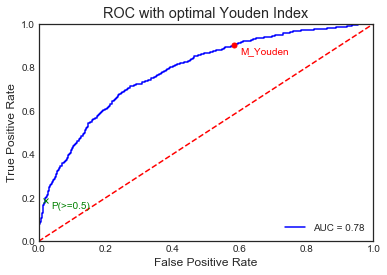


******* Using 0.5 Classification Threshold *******

[[2310   45]
 [ 606  139]]
the Accuracy is: 0.790
npv: 0.792
the classification_report:
               precision    recall  f1-score   support

           0      0.792     0.981     0.876      2355
           1      0.755     0.187     0.299       745

   micro avg      0.790     0.790     0.790      3100
   macro avg      0.774     0.584     0.588      3100
weighted avg      0.783     0.790     0.738      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.149
[[ 980 1375]
 [  73  672]]
the Accuracy is: 0.533
npv: 0.931
the classification_report:
               precision    recall  f1-score   support

           0      0.931     0.416     0.575      2355
           1      0.328     0.902     0.481       745

   micro avg      0.533     0.533     0.533      3100
   macro avg      0.629     0.659     0.528      3100
weighted avg      0.786     0.533     0.553      3100



{'auc': 0.7825851038059818,
 'f1': 0.4813753581661891,
 'model': 'RandomForestClassifier',
 'npv': 0.9306742640075973,
 'precision': 0.32828529555446995,
 'recall': 0.9020134228187919}

time: 515 ms


In [284]:
save_boolean=False
classifier_eval(models_24_dic['rf'],x=x_test_24,y=y_test_24, save=False)

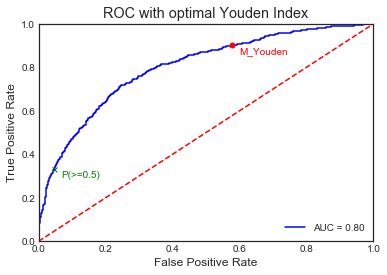


******* Using 0.5 Classification Threshold *******

[[2243  112]
 [ 497  248]]
the Accuracy is: 0.804
npv: 0.819
the classification_report:
               precision    recall  f1-score   support

           0      0.819     0.952     0.880      2355
           1      0.689     0.333     0.449       745

   micro avg      0.804     0.804     0.804      3100
   macro avg      0.754     0.643     0.665      3100
weighted avg      0.787     0.804     0.777      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.185
[[ 994 1361]
 [  74  671]]
the Accuracy is: 0.537
npv: 0.931
the classification_report:
               precision    recall  f1-score   support

           0      0.931     0.422     0.581      2355
           1      0.330     0.901     0.483       745

   micro avg      0.537     0.537     0.537      3100
   macro avg      0.630     0.661     0.532      3100
weighted avg      0.786     0.537     0.557      3100



{'auc': 0.7989010957693897,
 'f1': 0.4832553114872165,
 'model': 'RandomForestClassifier',
 'npv': 0.9307116104868914,
 'precision': 0.3302165354330709,
 'recall': 0.9006711409395973}

time: 414 ms


In [285]:
classifier_eval(models_24_dic['rf'],x=x_test_72,y=y_test_72, save=False)

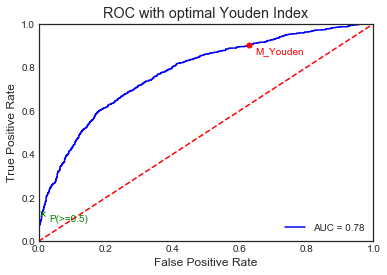


******* Using 0.5 Classification Threshold *******

[[2331   24]
 [ 648   97]]
the Accuracy is: 0.783
npv: 0.782
the classification_report:
               precision    recall  f1-score   support

           0      0.782     0.990     0.874      2355
           1      0.802     0.130     0.224       745

   micro avg      0.783     0.783     0.783      3100
   macro avg      0.792     0.560     0.549      3100
weighted avg      0.787     0.783     0.718      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.113
[[ 878 1477]
 [  73  672]]
the Accuracy is: 0.500
npv: 0.923
the classification_report:
               precision    recall  f1-score   support

           0      0.923     0.373     0.531      2355
           1      0.313     0.902     0.464       745

   micro avg      0.500     0.500     0.500      3100
   macro avg      0.618     0.637     0.498      3100
weighted avg      0.777     0.500     0.515      3100



{'auc': 0.7777571638239359,
 'f1': 0.46440912232204556,
 'model': 'RandomForestClassifier',
 'npv': 0.9232386961093586,
 'precision': 0.3127035830618892,
 'recall': 0.9020134228187919}

time: 432 ms


In [286]:
classifier_eval(models_72_dic['rf'],x=x_test_24,y=y_test_24, save=False)

In [248]:
len(list(x_test_24))

53

time: 2.32 ms


In [250]:
len(list(x_test_72))

54

time: 1.99 ms


In [251]:
set(x_test_72).difference(set(x_test_24))

{'gender_NA'}

time: 2.1 ms


In [298]:
def roc_publishing(model, x, y, proba_input=False,pos_label=1, print_default=True, model_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    import yellowbrick

    model_name=type(model).__name__

    y_pred = model.predict(x)
    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
    
    return(fpr, tpr, roc_auc, roc_df, idx)

time: 13.1 ms


In [301]:
def stacked_roc(x_test, y_test, models_dic, first_bold=True):
    """
    plotting function to plot a stacked ROC based on models in a dictionary. 
    first_bold=True means that the first model in the dic will stand out and be a solid line, while others are dotted
    """
    
    global save_boolean
    
    plt.style.use('seaborn-white')
    plt.rcParams['figure.figsize'] = [7, 4]
    import yellowbrick
    
    if first_bold==True: i=0
    else: i=1
        
    for model_name in models_dic.keys():
        #ax4= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
        if i==0:
            model=models_dic[model_name]
            fpr, tpr, roc_auc, roc_df, idx= roc_publishing(model, x=np.array(x_test), y=y_test, model_name=model_name)
            ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
            og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
            plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
            plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
        
        else:
            model=models_dic[model_name]
            fpr, tpr, roc_auc, roc_df, idx= roc_publishing(model, x=np.array(x_test), y=y_test, model_name=model_name)
            ax1= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
            og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
            plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
            plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
        i+=1
        
    ###annotating the plot
    plt.legend(loc = 'lower right')   
    plt.annotate(s="P(0.5)",xy=(0.78, 0.48),color='black', size=10) #textcoords #alt: xy=(0.78, 0.345)
    plt.plot(0.73, 0.49, 'ro', color='black') #alt: (0.73, 0.36, 'ro', color='black')
    plt.annotate(s="P(tuned)",xy=(0.78, 0.54),color='black', size=10) #textcoords #alt: xy=(0.78, 0.405)
    plt.plot(0.73, 0.55, 'ro', color='r') #alt: (0.73, 0.42, 'ro', color='r')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', size=14)
    plt.xlabel('False Positive Rate', size=14)

    if save_boolean==True:
        saveplot(plt,'stacked_roc')
    else: pass
    plt.show()

time: 90.1 ms


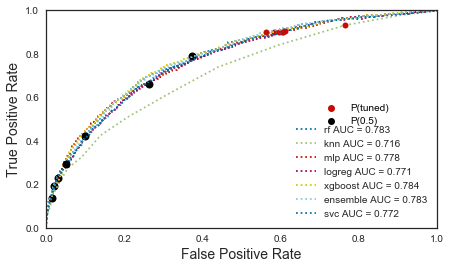

time: 5.7 s


In [303]:
save_boolean=False
stacked_roc(x_test_24, y_test_24, models_24_dic, first_bold=False)

# Evaluating misclassified patients
two different things to do:

1) Do tsne plot for ONLY the fn patients & for all pts with fn labeled 
    * look at visually. any structure apparent?
2) look at patients where ALL models misclassified as fn'
    * can also stratifiy patients by how many models misclassified as fn
   
-- these are related, if I id clusters, in #2 I can pick representative samples from each cluster. If there are clusters, I can pick representative samples from each cluster when comparing fn to other patients. 

-- so the hypothesis of this misclass investigation: is there a well characterized cluster of patients that our model is not recognizing?
Two ways:
--if so, we characterize the group and add another variable to annotate this. 
--other outcome: can’t improve model and need to talk about this in the discussion. 


In [15]:
def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)

time: 9.47 ms


In [16]:
def youden_predict(model, x, y, pos_label=1):
    import sklearn.metrics as metrics
    y_proba = model.predict_proba(x)[:,1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
    
    y_pred_youden = np.array([1. if y >= youden_threshold else 0. for y in y_proba])
    y_pred_youden= y_pred_youden.reshape(-1,1) #getting it the correct format
    
    return(y_pred_youden, youden_threshold)

time: 10.3 ms


In [17]:
def tabulate_confusion(y_test, youden_pred):
    "returns all # of tn, fp, fn, tp for each model"
    #print(youden_pred)### delte this after qc
    tn, fp, fn, tp =confusion_matrix(y_test, youden_pred).ravel()
    return(tn, fp, fn, tp)

time: 2.18 ms


In [18]:
##all wrapped up in a fxn
def tabulate_confusion_allmodel(model_dic, x_test, y_test):
    tn_list=[]
    fp_list=[]
    fn_list=[]
    tp_list=[]
    model=[]
    misclassified={}

    for key in model_dic.keys():
        print(key)
        youden_pred, youden_threshold=youden_predict(model=model_dic[str(key)],x=np.array(x_test),y=y_test)
        tn, fp, fn, tp= tabulate_confusion(y_test, youden_pred)
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)
        model.append(key)
        misclass= np.where(np.array(y_test).reshape(-1,) != np.asfarray(youden_pred).reshape(-1,))
        misclassified[str(key)]= np.array(misclass).reshape(-1)
    dic1={'model':model,
      'tn':tn_list,
      'fp':fp_list,
      'fn':fn_list,
      'tp':tp_list}
    
    return(pd.DataFrame(dic1),#.set_index('model'),
           misclassified)#, index=['rows'])

time: 21.4 ms


In [20]:
conf_24, misclassified_24= tabulate_confusion_allmodel(models_24_dic, x_test_24, y_test_24)

rf
knn
mlp
logreg
xgboost
ensemble
svc
time: 3.24 s


In [21]:
conf_24

,model,tn,fp,fn,tp
0,rf,980,1375,73,672
1,knn,553,1802,51,694
2,mlp,930,1425,73,672
3,logreg,924,1431,73,672
4,xgboost,951,1404,74,671
5,ensemble,1030,1325,74,671
6,svc,914,1441,71,674


time: 14.5 ms


In [22]:
for key in misclassified_24.keys():
    print(misclassified_24[str(key)].shape)

(1448,)
(1853,)
(1498,)
(1504,)
(1478,)
(1399,)
(1512,)
time: 1.42 ms


In [25]:
#positive= at or above threshold
#negative= below threshold
#false negative = 1 in y_true but <youden in pred. 
# y_pred_youden = [np.array(1.) if y >= youden_threshold else np.array(0.) for y in y_proba]

####false negatives are the ones we are most concerned about

time: 1.71 ms


In [ ]:
#### looking at just rf

In [23]:
def identify_fn_pts(model, x, y):
    """
    fxn to identify patients who were classified as a false negative: 1 in y_true but <youden_index in y_pred. 
    """
    
    #predict patient class probability with appropriate threshold
    youden_pred, youden_thresh=youden_predict(model=model,x=x,y=y)
    y_proba = model.predict_proba(x)[:,1]

    #identify the index and boolean list of rows that are false negatives for the above model. 
    fn_index=np.where((y_proba< youden_thresh) & (np.array(y['0'])==1.))[0]#.resize(-1)
    fn_bool=(y_proba< youden_thresh) & (np.array(y['0'])==1.)
    
    return(fn_bool, fn_index)
    
def fn_signif_vars(fn_bool, x, y):
    """
    more formally looking at t-test for all variable distributions: 
    comparing distribution of FN vs non-FN patients and finding list of only signif diff ones at p>=0.05.
    p_list is list of p value for each column.
    """
    from scipy import stats
   
    t_list=[]
    p_list=[]
    for element in list(x):
        fn= x.loc[fn_bool,element].tolist()
        nonfn= x.loc[~fn_bool,element].tolist() #using 0 as a test
        t2, p2 = stats.ttest_ind(fn,nonfn)
        p_list.append(p2)
        t_list.append(t2)
    return(p_list, t_list)

time: 29.1 ms


In [24]:
fn_bool, fn_index= identify_fn_pts(models_24_dic['rf'], x=x_test_24, y=y_test_24)
p_list, t_list=fn_signif_vars(fn_bool, x_test_24, y_test_24)

time: 290 ms


In [25]:
#list of sig vars
sig_vars=list(x_test_24.loc[fn_bool,list(np.array(p_list)<=0.05)])

time: 2.9 ms


In [26]:
x_test_24.loc[fn_bool,list(np.array(p_list)<=0.05)].head()#.describe()  ##df of fn rows with significant cols

,bun,creatinine,heartrate,inr,potassium,ptt,resprate,temperature,bicarbonate,diasbp,...,maxWBC,minWBC,bands_absent,pco2_absent,any_vasoactives_recieved,vent_recieved_None,vent_recieved_Oxygen,gender_M,norepinephrine_recieved,phenylephrine_recieved
66,-0.190472,-0.392317,0.086684,-0.567819,-0.062328,-0.097596,-0.024667,0.017545,-0.020978,-0.068782,...,0.191026,0.191026,1,1,1,0,0,0,0,1
86,0.117213,-0.222392,0.020719,-0.132111,0.030253,-0.104584,0.295842,0.013666,0.020155,-0.090239,...,-0.169309,-0.298932,1,1,0,0,1,1,0,0
124,-0.027032,0.131245,0.024042,0.000000,0.304288,0.044607,0.107309,-0.009848,-0.020978,-0.023432,...,-0.254082,-0.254082,1,1,0,0,1,0,0,0
133,-0.125965,-0.392317,-0.014622,-0.132111,-0.094452,-0.029685,0.087678,-0.027758,0.110545,-0.105336,...,-0.254082,-0.254082,1,1,0,1,0,0,0,0
157,-0.304712,-0.584963,0.105041,0.126488,0.145712,0.002104,0.023463,0.005874,-0.042850,-0.042131,...,-0.030293,-0.123747,1,1,0,1,0,0,0,0


time: 21.5 ms


In [ ]:
# #list of sig vars
# sig_vars=list(x_test_24.loc[fn_bool,list(np.array(p_list)<=0.05)])

# # library and dataset
# import seaborn as sns
# import matplotlib.pyplot as plt
# #import 
# ###plotting distribution of fn vs non-fn patients
# for element in sig_vars:
#     p1=sns.kdeplot(x_test_24.loc[fn_bool,element], shade=True, color="r",label="{}_fn".format(element))
#     p1=sns.kdeplot(x_test_24.loc[~fn_bool,element], shade=True, color="b",label="{}_non-fn".format(element))
#     plt.show()

### note from nelson:
100% focus should be on FN. Your goal is to minimize those patients, as those are the ones that could get you in trouble if you recommended stopping antibiotics. When you look at those, one interesting thing to look at will be their outcomes, meaning, are the FN outcomes more like the TN ones or the TP ones? This will answer the question: if you miss a FN is it a big deal (because their outcomes are as bad as the TP) or is it not as problematic because their outcomes are relatively good in general, so even stopping antibiotics early might not impact things too much… Hopefully that makes sense

# task 1: TSNE on false negatives

In [ ]:
# TSNE on false negatives. 
### try dimension reduction with full variables and with restricted variables
### mostly going to be a visual exploration

### if not very fruitful, don't spend too much time on this. 

In [27]:
from __future__ import print_function
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

time: 40.7 ms


In [28]:
from parameters import continuous_renamed
fn_bool

array([False, False, False, ..., False, False, False])

time: 2.53 ms


In [34]:
x_test_24.loc[fn_bool,continuous_renamed].head()

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,ptt,...,spo2,sysbp,maxCalcium,maxSodium,maxWBC,minCalcium,minSodium,minWBC,weight,yearsold
66,0.000000,-0.190472,-0.021780,-0.392317,0.095951,0.086684,-0.567819,0.075296,-0.062328,-0.097596,...,0.006245,-0.072069,0.082083,0.025249,0.191026,-0.250933,0.000000,0.191026,-1.339514,-0.240946
86,0.000000,0.117213,0.008428,-0.222392,-0.067222,0.020719,-0.132111,0.243529,0.030253,-0.104584,...,-0.052354,-0.075355,0.082083,0.010973,-0.169309,-0.250933,0.007342,-0.298932,-0.019188,0.170372
124,-0.198978,-0.027032,0.004234,0.131245,-0.013205,0.024042,0.000000,0.075296,0.304288,0.044607,...,-0.124684,-0.050047,0.082083,0.014580,-0.254082,-0.250933,0.007342,-0.254082,0.989787,-0.078123
133,0.168233,-0.125965,-0.094174,-0.392317,-0.021085,-0.014622,-0.132111,0.075296,-0.094452,-0.029685,...,-0.019120,-0.047032,0.082083,-0.071269,-0.254082,-0.250933,-0.079834,-0.254082,-0.259456,0.678185
157,0.000000,-0.304712,-0.017340,-0.584963,0.051172,0.105041,0.126488,-0.214681,0.145712,0.002104,...,-0.019120,-0.053094,-0.293458,-0.026554,-0.030293,-0.293458,-0.030462,-0.123747,-0.659865,-0.793999


time: 20.2 ms


In [57]:
##TSNE fit, only fitting the false neg with continuous variables
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x_test_24.loc[fn_bool,continuous_renamed])#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 72 nearest neighbors...
[t-SNE] Indexed 73 samples in 0.000s...
[t-SNE] Computed neighbors for 73 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 73 / 73
[t-SNE] Mean sigma: 1.115257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.805965
[t-SNE] KL divergence after 500 iterations: 0.730752
t-SNE done! Time elapsed: 0.21750283241271973 seconds
time: 220 ms


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window


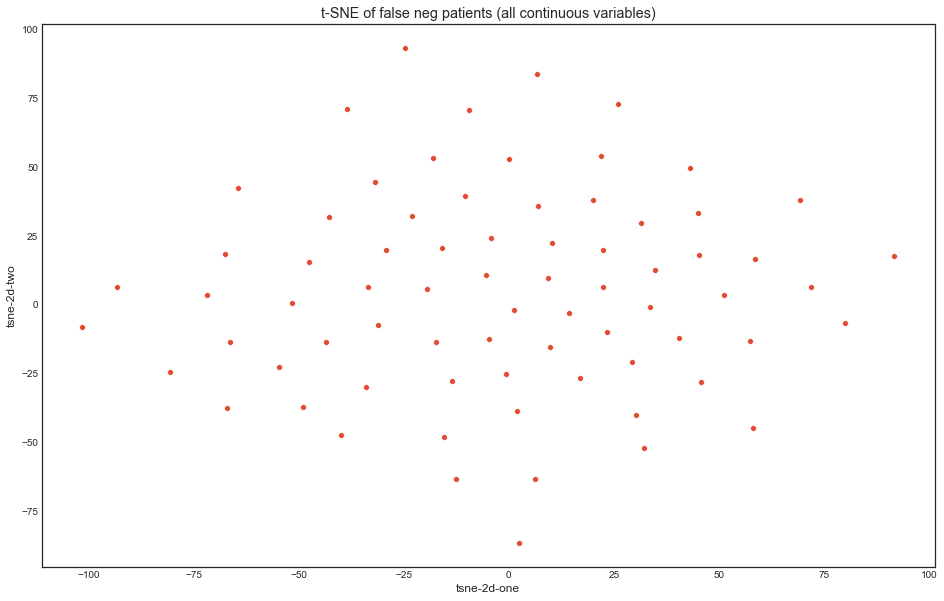

time: 488 ms


In [58]:
##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_test_24.loc[fn_bool,:].values

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                #hue='y',
                data=tsne_df,
                legend="full",
                alpha=1
)

ax.set_title('t-SNE of false neg patients (all continuous variables)')

saveplot(plt, figure_name="tsne_falseneg_cont")

In [59]:
##TSNE fit, fiting all pts with continuous variables and labeling the false negatives
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x_test_24.loc[:,continuous_renamed])#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3100 samples in 0.003s...
[t-SNE] Computed neighbors for 3100 samples in 0.439s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3100
[t-SNE] Computed conditional probabilities for sample 2000 / 3100
[t-SNE] Computed conditional probabilities for sample 3000 / 3100
[t-SNE] Computed conditional probabilities for sample 3100 / 3100
[t-SNE] Mean sigma: 0.423852
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.341377
[t-SNE] KL divergence after 500 iterations: 1.539709
t-SNE done! Time elapsed: 14.500787019729614 seconds
time: 14.5 s


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window


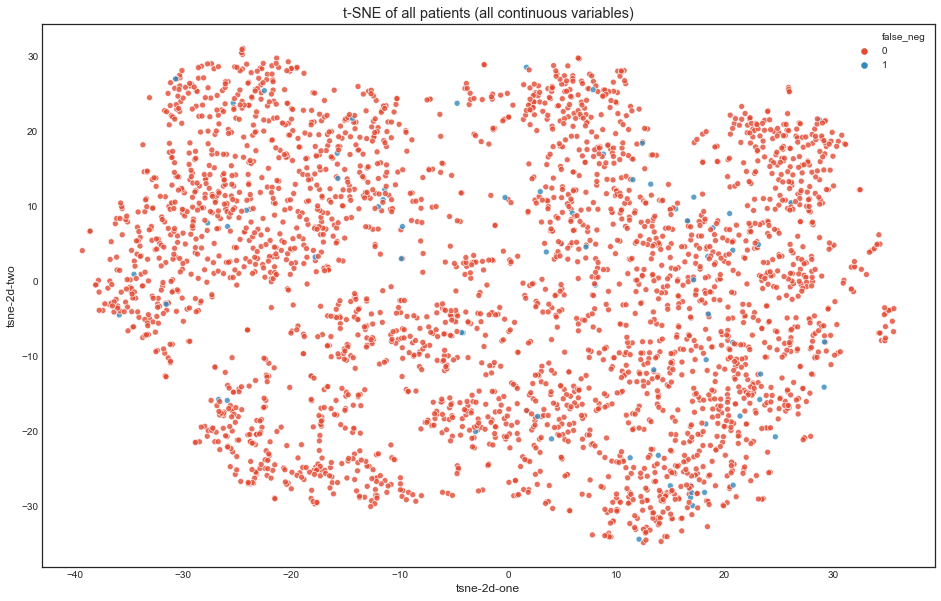

time: 1.19 s


In [60]:
##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
x_test_24_copy=x_test_24.copy()
x_test_24_copy['fn']=0
x_test_24_copy.loc[fn_bool,'fn']=1

tsne_df['false_neg']= x_test_24_copy['fn']#y_test_24.loc[fn_bool,:].values

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='false_neg',
                data=tsne_df,
                legend="full",
                alpha=0.8
)

ax.set_title('t-SNE of all patients (all continuous variables)')

#saveplot(figure_name='tsne_alltest_cont', folder_name='tsne')
saveplot(plt, figure_name="tsne_alltest_cont")

In [61]:
##TSNE fit, only fitting the false neg
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x_test_24.loc[fn_bool,sig_vars])#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 72 nearest neighbors...
[t-SNE] Indexed 73 samples in 0.000s...
[t-SNE] Computed neighbors for 73 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 73 / 73
[t-SNE] Mean sigma: 0.912962
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.991013
[t-SNE] KL divergence after 500 iterations: 0.478112
t-SNE done! Time elapsed: 0.25446295738220215 seconds
time: 258 ms


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window


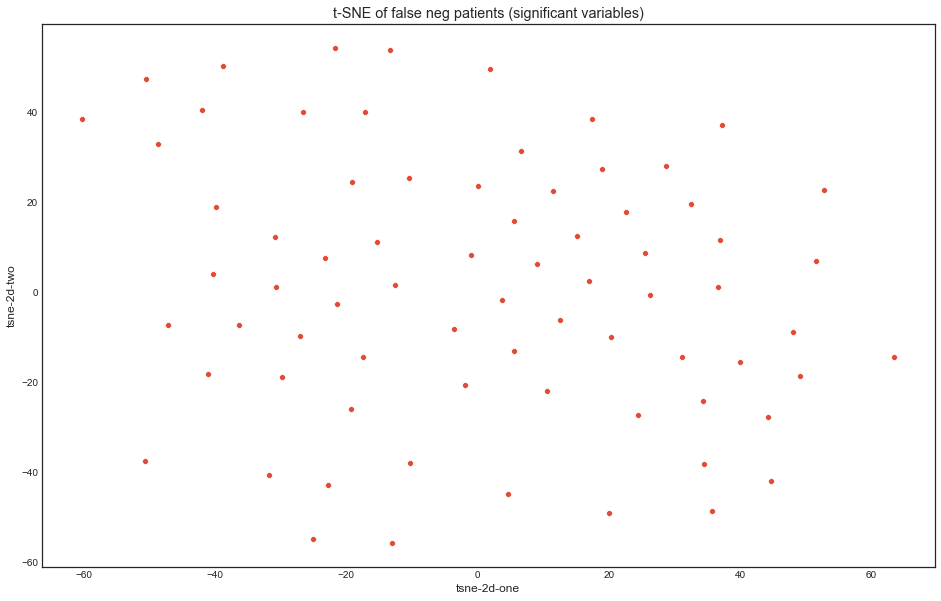

time: 411 ms


In [62]:
##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_test_24.loc[fn_bool,:].values

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                #hue='y',
                data=tsne_df,
                legend="full",
                alpha=1
)

ax.set_title('t-SNE of false neg patients (significant variables)')

saveplot(plt, figure_name="tsne_falseneg_signf")

In [63]:
##TSNE fit, fiting all pts with continuous variables and labeling the false negatives
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x_test_24.loc[:,sig_vars])#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3100 samples in 0.003s...
[t-SNE] Computed neighbors for 3100 samples in 0.410s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3100
[t-SNE] Computed conditional probabilities for sample 2000 / 3100
[t-SNE] Computed conditional probabilities for sample 3000 / 3100
[t-SNE] Computed conditional probabilities for sample 3100 / 3100
[t-SNE] Mean sigma: 0.342306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.500328
[t-SNE] KL divergence after 500 iterations: 0.806899
t-SNE done! Time elapsed: 12.460219144821167 seconds
time: 12.5 s


In [253]:
x_test_24.describe()

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,ptt,...,vent_recieved_Oxygen,dobutamine_recieved,gender_M,dopamine_recieved,epinephrine_recieved,norepinephrine_recieved,phenylephrine_recieved,rrt_recieved,vasopressin_recieved,cancer_elix_no_cancer_cormorb
count,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,...,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000
mean,0.103306,0.013969,0.000087,0.179463,0.054327,0.052227,0.292926,0.118755,0.075453,0.039101,...,0.489032,0.008387,0.551935,0.044839,0.027419,0.139032,0.135484,0.066452,0.017742,0.884194
std,0.501784,0.208942,0.028017,0.643233,0.095248,0.062022,0.766290,0.372444,0.216383,0.140623,...,0.499960,0.091211,0.497376,0.206983,0.163328,0.346036,0.342295,0.249110,0.132033,0.320044
min,-0.537467,-0.646015,-0.132350,-0.932886,-0.194416,-0.218930,-0.567819,-0.681175,-0.726162,-0.199282,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.125965,-0.017340,-0.222392,-0.013205,0.010532,-0.132111,0.038297,-0.062328,-0.038972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.045141,0.055449,0.126488,0.075296,0.059930,0.002104,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.158697,0.016704,0.415037,0.106861,0.094684,0.247811,0.075296,0.180062,0.061009,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.679094,0.702116,0.122342,3.777608,0.492241,0.293810,6.944931,2.485311,1.154473,0.535473,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


time: 297 ms


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window


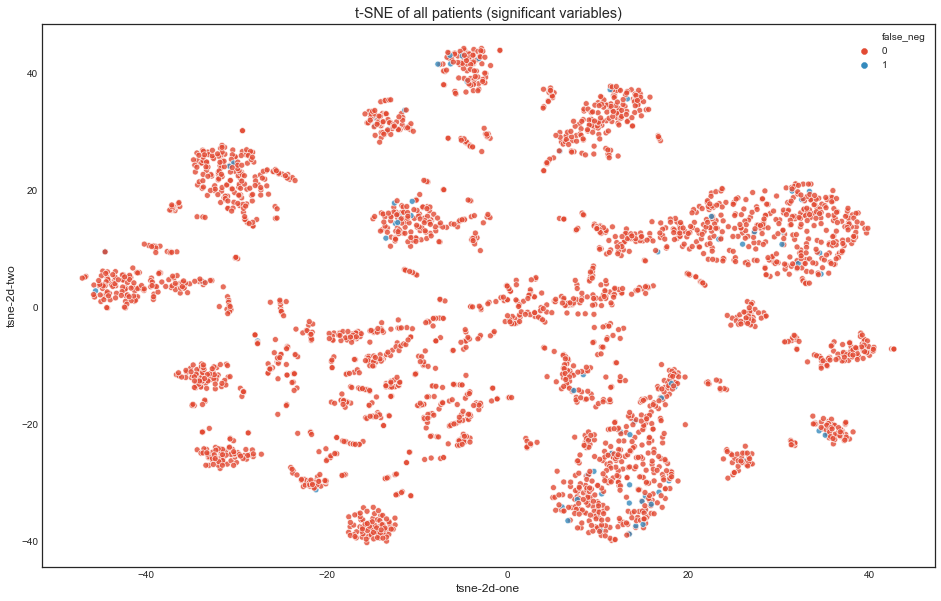

time: 909 ms


In [64]:
##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['false_neg']= x_test_24_copy['fn']#y_test_24.loc[fn_bool,:].values

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='false_neg',
                data=tsne_df,
                legend="full",
                alpha=0.8
)

ax.set_title('t-SNE of all patients (significant variables)')
saveplot(plt, figure_name="tsne_alltest_signif")
#saveplot(figure_name='global_training_tsne', folder_name='tsne')

In [ ]:
### are there distinct clusters here? i would say yes but there are a lot and might be hard to grab ppl from them

In [ ]:
# can do a boxplot for each of the clusters. to distinguish them

In [254]:
tsne_df

,tsne-2d-one,tsne-2d-two,multi_false_neg
0,1.092864,0.644415,0
1,3.961948,6.821091,1
2,1.096714,0.889384,0
3,-3.962289,1.781922,0
4,-4.946171,-2.406316,0
5,-3.190686,-3.254639,1
6,-1.562820,1.795336,0
7,4.758463,-1.170253,1
8,3.017368,6.006782,1
9,4.440062,-1.177703,0


time: 18.7 ms


## investigate misclass #2: 
2) look at patients where ALL models misclassified as fn'
    * can also stratifiy patients by how many models misclassified as fn
   
-- these are related, if I id clusters, in #2 I can pick representative samples from each cluster. If there are clusters, I can pick representative samples from each cluster when comparing fn to other patients. 

In [29]:
fn_24_dic={}

#put hte row index of fn for each model
for key in models_24_dic.keys():
    fn_bool, fn_index= identify_fn_pts(models_24_dic[key], x=np.array(x_test_24), y=y_test_24)
    fn_24_dic.update({key: list(fn_index)})


time: 6.08 s


In [113]:
fn_24_dic

{'ensemble': [66,
  124,
  127,
  133,
  154,
  157,
  185,
  247,
  266,
  273,
  393,
  505,
  506,
  575,
  807,
  820,
  931,
  1047,
  1067,
  1072,
  1077,
  1134,
  1140,
  1177,
  1187,
  1257,
  1322,
  1414,
  1431,
  1463,
  1502,
  1509,
  1564,
  1577,
  1610,
  1639,
  1667,
  1678,
  1707,
  1763,
  1827,
  1849,
  1883,
  1910,
  1924,
  1954,
  1961,
  1971,
  2034,
  2058,
  2081,
  2091,
  2092,
  2104,
  2155,
  2239,
  2312,
  2356,
  2401,
  2502,
  2508,
  2520,
  2556,
  2573,
  2594,
  2650,
  2683,
  2826,
  2828,
  2920,
  3046],
 'knn': [97,
  124,
  133,
  273,
  295,
  521,
  528,
  647,
  675,
  724,
  806,
  1067,
  1077,
  1140,
  1177,
  1207,
  1219,
  1257,
  1261,
  1281,
  1292,
  1427,
  1431,
  1477,
  1639,
  1667,
  1678,
  1849,
  1924,
  1954,
  2021,
  2058,
  2081,
  2104,
  2112,
  2155,
  2200,
  2239,
  2356,
  2415,
  2508,
  2519,
  2594,
  2623,
  2637,
  2688,
  2702,
  2815,
  2828,
  2902,
  2985],
 'logreg': [66,
  124,
  127,
  1

time: 29.8 ms


In [66]:
models_24_dic.keys()

dict_keys(['rf', 'knn', 'mlp', 'logreg', 'xgboost', 'ensemble', 'svc'])

time: 3.4 ms


In [30]:
total_lists=[]

for element in fn_24_dic:
    total_lists.append(fn_24_dic[element])
    
total_list=[item for sublist in total_lists for item in sublist]

time: 2.71 ms


In [115]:
fn_24_dic['ensemble']

[66,
 124,
 127,
 133,
 154,
 157,
 185,
 247,
 266,
 273,
 393,
 505,
 506,
 575,
 807,
 820,
 931,
 1047,
 1067,
 1072,
 1077,
 1134,
 1140,
 1177,
 1187,
 1257,
 1322,
 1414,
 1431,
 1463,
 1502,
 1509,
 1564,
 1577,
 1610,
 1639,
 1667,
 1678,
 1707,
 1763,
 1827,
 1849,
 1883,
 1910,
 1924,
 1954,
 1961,
 1971,
 2034,
 2058,
 2081,
 2091,
 2092,
 2104,
 2155,
 2239,
 2312,
 2356,
 2401,
 2502,
 2508,
 2520,
 2556,
 2573,
 2594,
 2650,
 2683,
 2826,
 2828,
 2920,
 3046]

time: 4.62 ms


In [31]:
fn_count_df= pd.DataFrame(index=set(total_list), columns=fn_24_dic.keys() )

time: 5.31 ms


In [32]:
fn_count_df[fn_count_df.isnull()]=0
for key in fn_24_dic.keys():
    fn_count_df.loc[fn_24_dic[key],key]=1

time: 11.4 ms


In [33]:
fn_count_df['fn_model_count']=fn_count_df.sum(axis=1)
fn_count_df.reset_index(inplace=True)

time: 3.31 ms


In [36]:
fn_count_df['fn_model_count'].value_counts()

1    48
6    28
2    17
7    14
5    13
4    13
3     8
Name: fn_model_count, dtype: int64

time: 4.03 ms


In [37]:
fn_count_df

,index,rf,knn,mlp,logreg,xgboost,ensemble,svc,fn_model_count
0,1541,1,0,1,1,0,1,0,4
1,2566,0,0,0,1,0,0,1,2
2,521,1,1,0,0,0,0,0,2
3,2058,0,1,1,1,0,1,0,4
4,2573,1,0,0,0,0,1,0,2
5,2575,0,0,0,0,1,0,0,1
6,528,0,1,0,0,0,0,0,1
7,1041,1,0,0,0,1,0,0,2
8,533,1,0,0,0,0,0,0,1
9,1047,1,0,1,1,1,1,1,6


time: 28.3 ms


In [38]:
fn_count_df.sort_values('fn_model_count', ascending=False)

,index,rf,knn,mlp,logreg,xgboost,ensemble,svc,fn_model_count
45,124,1,1,1,1,1,1,1,7
11,2081,1,1,1,1,1,1,1,7
115,1431,1,1,1,1,1,1,1,7
116,1954,1,1,1,1,1,1,1,7
40,2155,1,1,1,1,1,1,1,7
88,2828,1,1,1,1,1,1,1,7
43,1140,1,1,1,1,1,1,1,7
12,2594,1,1,1,1,1,1,1,7
98,2356,1,1,1,1,1,1,1,7
54,1678,1,1,1,1,1,1,1,7


time: 23.4 ms


In [39]:
len(fn_count_df[fn_count_df['fn_model_count']>=5.0]) #so 50/160 were misclassified by 5+/7 models


55

time: 4.29 ms


In [40]:
multi_fn_list=fn_count_df.loc[fn_count_df['fn_model_count']>=5.0,'index'].to_list()
#multi_fn_list=fn_count_df.loc[fn_count_df['fn_model_count']>=5.0,'index'].to_list()

time: 1.91 ms


In [41]:
#annotating x_test with fn and multi_fn (>=5)
x_test_24_copy=x_test_24.copy()
x_test_24_copy.reset_index(inplace=True)
x_test_24_copy['fn']=0
x_test_24_copy['multi_fn']=0
x_test_24_copy.loc[fn_bool,'fn']=1
x_test_24_copy.loc[x_test_24_copy["index"].isin(multi_fn_list),'multi_fn']=1

time: 11 ms


In [204]:
multi_fn_list

[1047,
 2081,
 2594,
 1577,
 2091,
 1072,
 2104,
 575,
 66,
 2650,
 1639,
 2155,
 1134,
 1140,
 2683,
 124,
 1667,
 133,
 1678,
 1177,
 154,
 1187,
 1707,
 185,
 2239,
 1763,
 1257,
 2312,
 2826,
 2828,
 1827,
 820,
 2356,
 1883,
 2401,
 2920,
 1924,
 393,
 1431,
 1954,
 1961,
 1971,
 1463,
 2502,
 2508,
 2520,
 2034,
 505,
 506,
 2556]

time: 2.23 ms


In [57]:
##TSNE fit, fiting all pts with continuous variables and labeling the false negatives
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x_test_24.loc[:,sig_vars])#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3100 samples in 0.002s...
[t-SNE] Computed neighbors for 3100 samples in 0.376s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3100
[t-SNE] Computed conditional probabilities for sample 2000 / 3100
[t-SNE] Computed conditional probabilities for sample 3000 / 3100
[t-SNE] Computed conditional probabilities for sample 3100 / 3100
[t-SNE] Mean sigma: 0.342306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.712997
[t-SNE] KL divergence after 500 iterations: 0.806859
t-SNE done! Time elapsed: 12.784151077270508 seconds
time: 12.8 s


In [55]:
x_test_24_copy.loc[x_test_24_copy['multi_fn']==1, 'fn']=2

time: 3.61 ms


In [62]:
plt.style.use('seaborn-white')

time: 826 µs


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


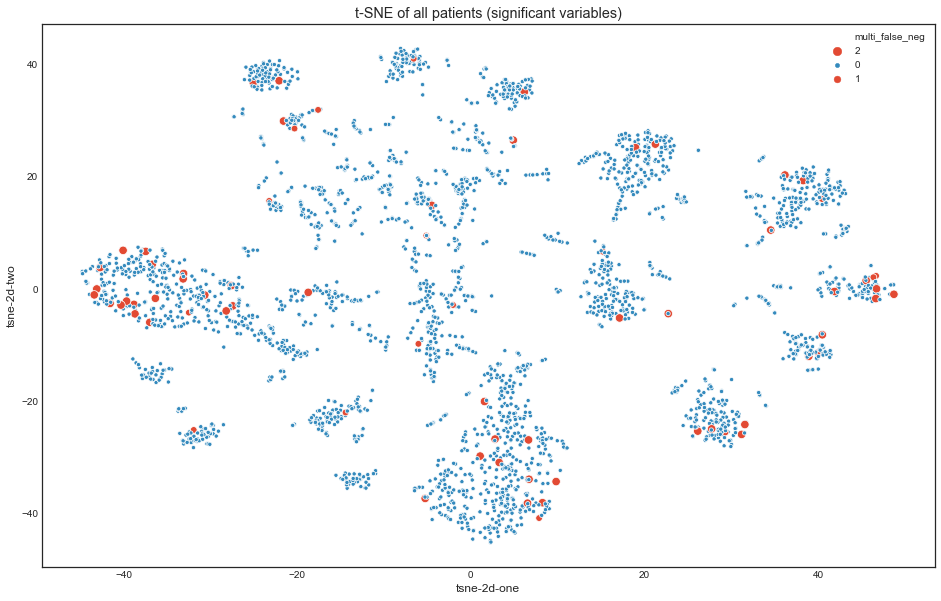

time: 747 ms


In [132]:
##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['multi_false_neg']= x_test_24_copy['fn']#y_test_24.loc[fn_bool,:].values

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='multi_false_neg',
                data=tsne_df,
                legend="full",
                size='multi_false_neg',
                #alpha=0.7,
                #palette=sns.color_palette('Set1')[-0:3], hue_order=[1,2,0]
                palette=[(0.8862745098039215, 0.2901960784313726, 0.2),
 (0.20392156862745098, 0.5411764705882353, 0.7411764705882353),
(0.8862745098039215, 0.2901960784313726, 0.2)], #sns.color_palette()[0:3], (0.7862745098039215, 0.5901960784313726, 0.4)
                    hue_order=[2,0,1]#[1,2,0]
)

ax.set_title('t-SNE of all patients (significant variables)')
saveplot(plt, figure_name="tsne_alltest_multiFN_signif")
#saveplot(figure_name='global_training_tsne', folder_name='tsne')

In [133]:
tsne_df

,tsne-2d-one,tsne-2d-two,multi_false_neg
0,-20.323864,-24.133837,0
1,36.976463,15.452258,0
2,1.636482,39.162968,0
3,-1.631030,18.120733,0
4,43.622204,-1.737505,0
5,-19.512865,30.594652,0
6,8.581290,-28.559044,0
7,-2.414068,-41.124557,0
8,-9.069703,12.590218,0
9,-24.583118,6.826476,0


time: 14.1 ms


In [134]:
len(x_test_24.loc[:,sig_vars])
#between -10: 10 on y, and <-20 on x 

3100

time: 3.69 ms


In [ ]:
v

In [109]:
sns.color_palette('Set1')[0:3]

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)]

time: 2.8 ms


In [117]:
sns.color_palette(n_colors=9)

[(0.8862745098039215, 0.2901960784313726, 0.2),
 (0.20392156862745098, 0.5411764705882353, 0.7411764705882353),
 (0.596078431372549, 0.5568627450980392, 0.8352941176470589),
 (0.4666666666666667, 0.4666666666666667, 0.4666666666666667),
 (0.984313725490196, 0.7568627450980392, 0.3686274509803922),
 (0.5568627450980392, 0.7294117647058823, 0.25882352941176473),
 (1.0, 0.7098039215686275, 0.7215686274509804),
 (0.8862745098039215, 0.2901960784313726, 0.2),
 (0.20392156862745098, 0.5411764705882353, 0.7411764705882353)]

time: 2.72 ms


In [ ]:
[(0.8862745098039215, 0.2901960784313726, 0.2),
 (0.20392156862745098, 0.5411764705882353, 0.7411764705882353),
 (0.4666666666666667, 0.4666666666666667, 0.4666666666666667)]

In [104]:
sns.color_palette()[[1,2,3,4]]

TypeError: list indices must be integers or slices, not list

time: 8.17 ms


In [ ]:
#### send this

In [268]:
##TSNE fit, fiting all pts with continuous variables and labeling the false negatives
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list), sig_vars])#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 160 samples in 0.000s...
[t-SNE] Computed neighbors for 160 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 160 / 160
[t-SNE] Mean sigma: 0.741902
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.888718
[t-SNE] KL divergence after 500 iterations: 0.298708
t-SNE done! Time elapsed: 0.4407830238342285 seconds
time: 443 ms


Text(0.5, 1.0, 't-SNE of all patients with a falseneg (significant variables)')

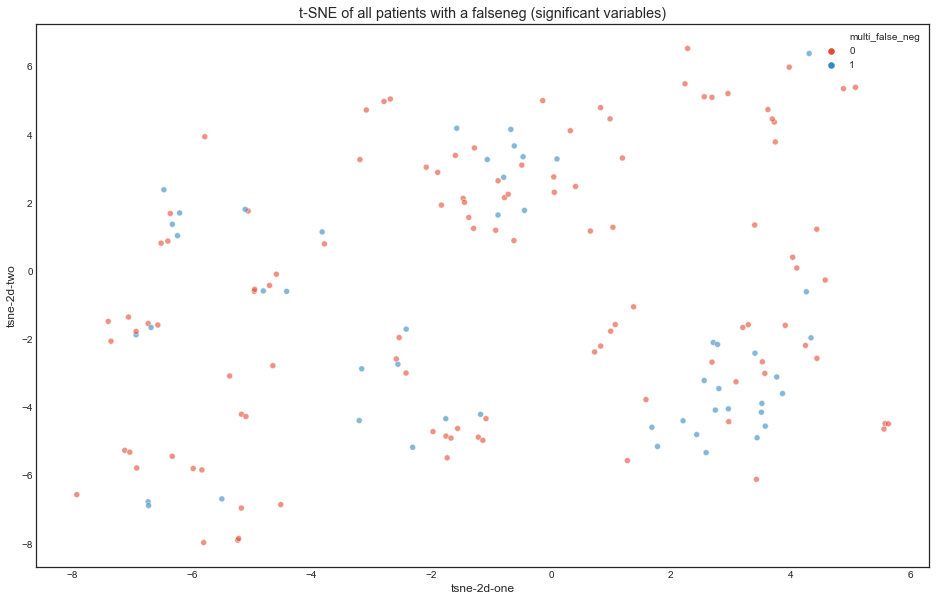

time: 292 ms


In [269]:
#x_test_24_copy.loc[x_test_24_copy['fn']==1, sig_vars]

##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['multi_false_neg']=list(x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list),'multi_fn'])

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='multi_false_neg',
                data=tsne_df,
                legend="full",
                alpha=0.6
)

ax.set_title('t-SNE of all patients with a falseneg (significant variables)')
#saveplot(plt, figure_name="tsne_FN_multiFN_signif")
#saveplot(figure_name='global_training_tsne', folder_name='tsne')

In [270]:
tsne_df

,tsne-2d-one,tsne-2d-two,multi_false_neg
0,-6.566439,-1.589046,0
1,-5.496107,-6.690881,1
2,-6.727443,-1.544532,0
3,-1.891333,2.890952,0
4,4.582433,-0.268601,0
5,2.712781,-2.103144,1
6,-0.617196,0.888781,0
7,-2.555650,-2.739412,1
8,-6.728393,-6.775707,1
9,-2.420025,-2.996887,0


time: 14.8 ms


In [266]:
#### send this
x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list), sig_vars]
#sum(list(x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list),'multi_fn']))

50

time: 6.08 ms


In [43]:
##### repeating above

time: 504 µs


In [51]:
##TSNE fit, fiting all pts with continuous variables and labeling the false negatives
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list), sig_vars])#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 141 samples in 0.000s...
[t-SNE] Computed neighbors for 141 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 141 / 141
[t-SNE] Mean sigma: 0.761717
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.238239
[t-SNE] KL divergence after 1000 iterations: 0.279981
t-SNE done! Time elapsed: 0.7536790370941162 seconds
time: 756 ms


Text(0.5, 1.0, 't-SNE of all patients with a falseneg (significant variables)')

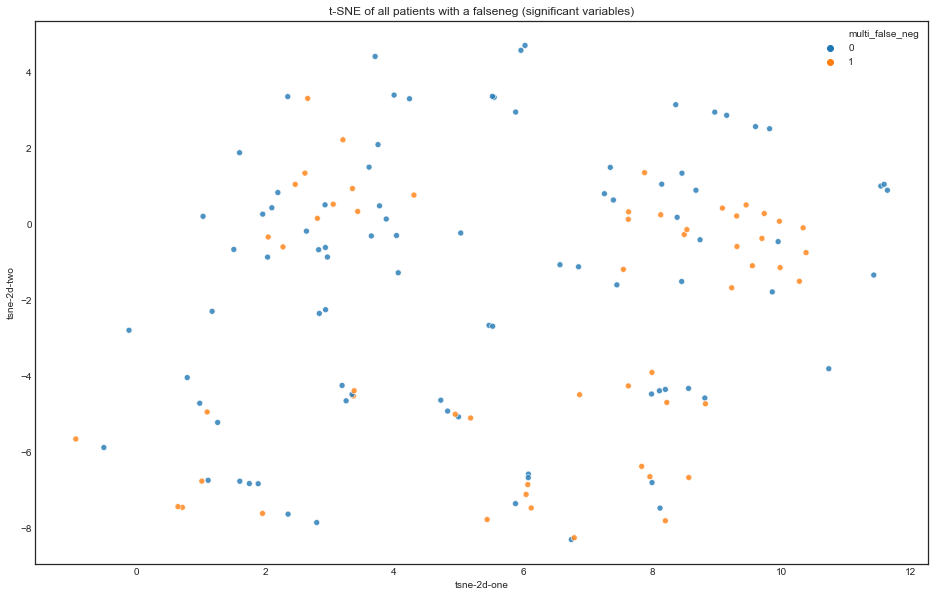

time: 296 ms


In [52]:
#x_test_24_copy.loc[x_test_24_copy['fn']==1, sig_vars]

##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['multi_false_neg']=list(x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list),'multi_fn'])

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='multi_false_neg',
                data=tsne_df,
                legend="full",
                alpha=0.8
)

ax.set_title('t-SNE of all patients with a falseneg (significant variables)')
#saveplot(plt, figure_name="tsne_FN_multiFN_signif")
#saveplot(figure_name='global_training_tsne', folder_name='tsne')

In [270]:
tsne_df

,tsne-2d-one,tsne-2d-two,multi_false_neg
0,-6.566439,-1.589046,0
1,-5.496107,-6.690881,1
2,-6.727443,-1.544532,0
3,-1.891333,2.890952,0
4,4.582433,-0.268601,0
5,2.712781,-2.103144,1
6,-0.617196,0.888781,0
7,-2.555650,-2.739412,1
8,-6.728393,-6.775707,1
9,-2.420025,-2.996887,0


time: 14.8 ms


In [258]:
##TSNE fit, fiting all pts with continuous variables and labeling the false negatives
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list), continuous_renamed])#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 160 samples in 0.000s...
[t-SNE] Computed neighbors for 160 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 160 / 160
[t-SNE] Mean sigma: 0.887615
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.652142
[t-SNE] KL divergence after 500 iterations: 0.439766
t-SNE done! Time elapsed: 0.658574104309082 seconds
time: 664 ms


Text(0.5, 1.0, 't-SNE of all patients with a falseneg (significant variables)')

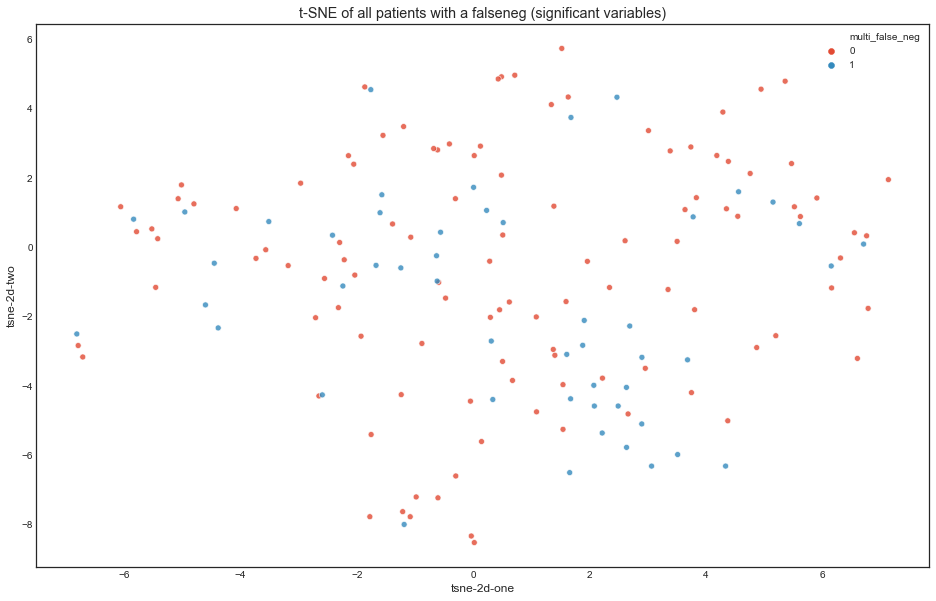

time: 521 ms


In [259]:
#x_test_24_copy.loc[x_test_24_copy['fn']==1, sig_vars]

##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['multi_false_neg']=list(x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list),'multi_fn'])

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='multi_false_neg',
                data=tsne_df,
                legend="full",
                alpha=0.8
)

ax.set_title('t-SNE of all patients with a falseneg (continuous variables)')
#saveplot(plt, figure_name="tsne_FNtest_signif")
#saveplot(figure_name='global_training_tsne', folder_name='tsne')

In [257]:
x_test_24_copy.describe()

,index,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,gender_M,dopamine_recieved,epinephrine_recieved,norepinephrine_recieved,phenylephrine_recieved,rrt_recieved,vasopressin_recieved,cancer_elix_no_cancer_cormorb,fn,multi_fn
count,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,...,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000
mean,1549.500000,0.103306,0.013969,0.000087,0.179463,0.054327,0.052227,0.292926,0.118755,0.075453,...,0.551935,0.044839,0.027419,0.139032,0.135484,0.066452,0.017742,0.884194,0.022903,0.016129
std,895.037243,0.501784,0.208942,0.028017,0.643233,0.095248,0.062022,0.766290,0.372444,0.216383,...,0.497376,0.206983,0.163328,0.346036,0.342295,0.249110,0.132033,0.320044,0.149619,0.125992
min,0.000000,-0.537467,-0.646015,-0.132350,-0.932886,-0.194416,-0.218930,-0.567819,-0.681175,-0.726162,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,774.750000,0.000000,-0.125965,-0.017340,-0.222392,-0.013205,0.010532,-0.132111,0.038297,-0.062328,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1549.500000,0.000000,0.000000,0.000000,0.000000,0.045141,0.055449,0.126488,0.075296,0.059930,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2324.250000,0.000000,0.158697,0.016704,0.415037,0.106861,0.094684,0.247811,0.075296,0.180062,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3099.000000,3.679094,0.702116,0.122342,3.777608,0.492241,0.293810,6.944931,2.485311,1.154473,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


time: 308 ms


In [227]:
#tsne_df
tsne_df['multi_false_neg']=list(x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list),'multi_fn'])
tsne_df

,tsne-2d-one,tsne-2d-two,multi_false_neg
0,1.092864,0.644415,0
1,3.961948,6.821091,1
2,1.096714,0.889384,0
3,-3.962289,1.781922,0
4,-4.946171,-2.406316,0
5,-3.190686,-3.254639,1
6,-1.562820,1.795336,0
7,4.758463,-1.170253,1
8,3.017368,6.006782,1
9,4.440062,-1.177703,0


time: 15.7 ms


In [211]:
len(x_test_24_copy.loc[x_test_24_copy['index'].isin(total_list),'multi_fn'])

160

time: 3 ms


In [201]:
len(x_test_24_copy.loc[x_test_24_copy['fn']==1, sig_vars])

71

time: 6.82 ms


In [203]:
#x_test_24_copy.loc[x_test_24_copy['fn']==1,'multi_fn']
len(x_test_24_copy.loc[x_test_24_copy['fn']==1, sig_vars])

71

time: 5.1 ms


# investigating the misclassified in tsne

In [57]:
##TSNE fit, fiting all pts with continuous variables and labeling the false negatives
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x_test_24.loc[:,sig_vars])#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3100 samples in 0.002s...
[t-SNE] Computed neighbors for 3100 samples in 0.376s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3100
[t-SNE] Computed conditional probabilities for sample 2000 / 3100
[t-SNE] Computed conditional probabilities for sample 3000 / 3100
[t-SNE] Computed conditional probabilities for sample 3100 / 3100
[t-SNE] Mean sigma: 0.342306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.712997
[t-SNE] KL divergence after 500 iterations: 0.806859
t-SNE done! Time elapsed: 12.784151077270508 seconds
time: 12.8 s


In [55]:
x_test_24_copy.loc[x_test_24_copy['multi_fn']==1, 'fn']=2

time: 3.61 ms


In [62]:
plt.style.use('seaborn-white')

time: 826 µs


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


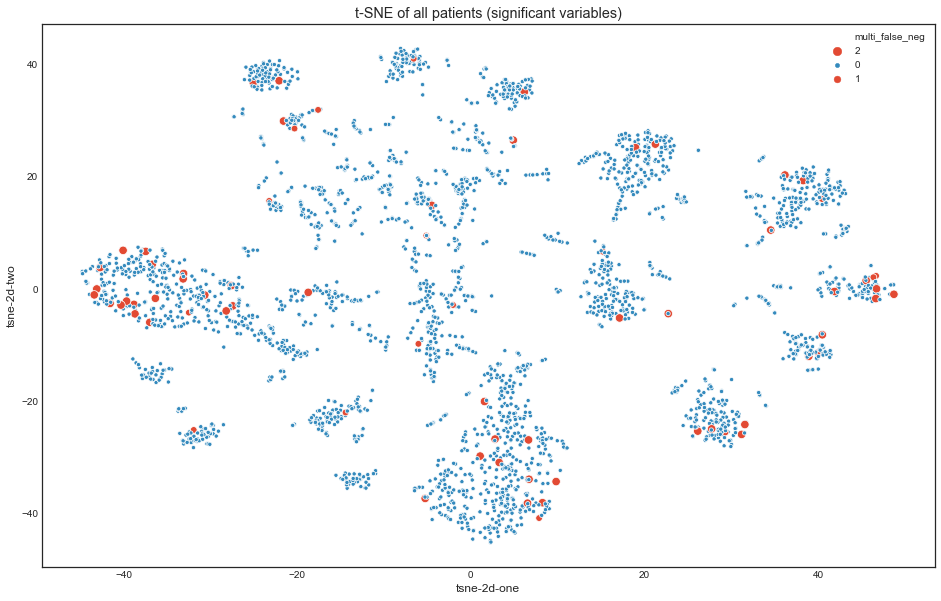

time: 768 ms


In [139]:
##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['multi_false_neg']= x_test_24_copy['fn']#y_test_24.loc[fn_bool,:].values

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='multi_false_neg',
                data=tsne_df,
                legend="full",
                size='multi_false_neg',
                #alpha=0.7,
                #palette=sns.color_palette('Set1')[-0:3], hue_order=[1,2,0]
                palette=[(0.8862745098039215, 0.2901960784313726, 0.2),
 (0.20392156862745098, 0.5411764705882353, 0.7411764705882353),
(0.8862745098039215, 0.2901960784313726, 0.2)], #sns.color_palette()[0:3], (0.7862745098039215, 0.5901960784313726, 0.4)
                    hue_order=[2,0,1]#[1,2,0]
)

# ax.set_title('t-SNE of all patients (significant variables)')
# saveplot(plt, figure_name="tsne_alltest_multiFN_signif")
#saveplot(figure_name='global_training_tsne', folder_name='tsne')

In [133]:
tsne_df

,tsne-2d-one,tsne-2d-two,multi_false_neg
0,-20.323864,-24.133837,0
1,36.976463,15.452258,0
2,1.636482,39.162968,0
3,-1.631030,18.120733,0
4,43.622204,-1.737505,0
5,-19.512865,30.594652,0
6,8.581290,-28.559044,0
7,-2.414068,-41.124557,0
8,-9.069703,12.590218,0
9,-24.583118,6.826476,0


time: 14.1 ms


In [134]:
len(x_test_24.loc[:,sig_vars])
#between -10: 10 on y, and <-20 on x 

3100

time: 3.69 ms


In [142]:
cluster_1=tsne_df[(tsne_df['tsne-2d-two'].between(-15,15) )& (tsne_df['tsne-2d-one']<-20)]

time: 3.6 ms


In [165]:
cluster_2=tsne_df[(tsne_df['tsne-2d-one'].between(-10,10) )& (tsne_df['tsne-2d-two']<-20)]

time: 3.71 ms


In [143]:
cluster_1['multi_false_neg'].value_counts()

0    421
2     19
1      1
Name: multi_false_neg, dtype: int64

time: 4.67 ms


In [144]:
tsne_df['multi_false_neg'].value_counts()

0    3029
2      55
1      16
Name: multi_false_neg, dtype: int64

time: 3.87 ms


In [ ]:
# so a disporportionate # of false negatives are here in cluster1. 

In [152]:
cluster_1.loc[cluster_1['multi_false_neg']!=0].index.values

array([ 124,  807,  820, 1072, 1134, 1140, 1463, 1577, 1639, 1763, 1827,
       1849, 1924, 1971, 2155, 2312, 2594, 2650, 2828, 2920])

time: 3.83 ms


#### looking at distribution of false neg in cluster 1 vs all in cluster2

In [162]:
x_test_24.loc[cluster_1[cluster_1['multi_false_neg']!=0].index.values,sig_vars].describe()

,bun,creatinine,heartrate,inr,potassium,ptt,resprate,temperature,bicarbonate,diasbp,...,maxWBC,minWBC,bands_absent,pco2_absent,any_vasoactives_recieved,vent_recieved_None,vent_recieved_Oxygen,gender_M,norepinephrine_recieved,phenylephrine_recieved
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,-0.124747,-0.260202,0.041831,-0.091532,-0.020412,0.019981,0.141332,-0.000950,0.018090,-0.069815,...,-0.024937,-0.051766,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
std,0.151235,0.280403,0.053118,0.199033,0.176835,0.156471,0.069817,0.021518,0.078977,0.069785,...,0.194466,0.201610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-0.382787,-0.807355,-0.058791,-0.415374,-0.265832,-0.156081,-0.024667,-0.029763,-0.114673,-0.235409,...,-0.512766,-0.512766,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
25%,-0.215338,-0.415595,0.018031,-0.270369,-0.160760,-0.066499,0.107309,-0.017284,-0.020978,-0.107288,...,-0.104261,-0.199580,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
50%,-0.146707,-0.304855,0.049356,-0.132111,-0.078390,0.002104,0.126171,0.001959,0.000000,-0.065351,...,0.036324,-0.012749,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
75%,-0.027032,0.000000,0.078472,0.126488,0.117640,0.010129,0.186702,0.009776,0.044222,-0.021929,...,0.091185,0.070924,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
max,0.202116,0.192645,0.127153,0.126488,0.304288,0.535473,0.255178,0.057612,0.215175,0.042508,...,0.275834,0.275834,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


time: 85.4 ms


In [167]:
x_test_24.loc[cluster_2.index.values,sig_vars].describe()

,bun,creatinine,heartrate,inr,potassium,ptt,resprate,temperature,bicarbonate,diasbp,...,maxWBC,minWBC,bands_absent,pco2_absent,any_vasoactives_recieved,vent_recieved_None,vent_recieved_Oxygen,gender_M,norepinephrine_recieved,phenylephrine_recieved
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,...,417.000000,417.000000,417.0,417.0,417.000000,417.0,417.0,417.0,417.0,417.0
mean,-0.014227,0.026917,0.041737,0.041651,0.028377,0.014363,0.151551,0.017665,-0.006938,-0.082075,...,-0.035092,-0.057156,1.0,1.0,0.031175,0.0,1.0,1.0,0.0,0.0
std,0.177570,0.346257,0.060034,0.228022,0.163108,0.123864,0.097891,0.030848,0.090550,0.083280,...,0.241705,0.243536,0.0,0.0,0.173999,0.0,0.0,0.0,0.0,0.0
min,-0.556641,-0.807355,-0.153972,-0.567819,-0.499970,-0.171043,-0.138346,-0.133178,-0.585553,-0.428310,...,-1.122174,-1.122174,1.0,1.0,0.000000,0.0,1.0,1.0,0.0,0.0
25%,-0.146015,-0.222392,-0.003592,-0.132111,-0.062328,-0.044901,0.087678,-0.001964,-0.042850,-0.121135,...,-0.157505,-0.187581,1.0,1.0,0.000000,0.0,1.0,1.0,0.0,0.0
50%,-0.013222,0.000000,0.043264,0.126488,0.000000,0.002104,0.144320,0.011722,0.000000,-0.075785,...,-0.004212,-0.017075,1.0,1.0,0.000000,0.0,1.0,1.0,0.0,0.0
75%,0.108208,0.192645,0.081233,0.126488,0.117640,0.002104,0.210756,0.034864,0.039550,-0.023432,...,0.111678,0.087856,1.0,1.0,0.000000,0.0,1.0,1.0,0.0,0.0
max,0.500000,1.099536,0.293810,0.789673,0.621493,0.535473,0.512018,0.141044,0.228523,0.163144,...,0.549704,0.460950,1.0,1.0,1.000000,0.0,1.0,1.0,0.0,0.0


time: 75.9 ms


In [ ]:
x_test_24.loc[cluster_2[cluster_2['multi_false_neg']!=0].index.values,sig_vars].describe()

In [177]:
p_list, t_list=signif_vars(x_test_24.loc[cluster_1[cluster_1['multi_false_neg']!=0].index.values,sig_vars], x_test_24.loc[cluster_2.index.values,sig_vars] )

time: 17.7 ms


In [189]:
clust1v2_sig=pd.DataFrame(np.array(p_list).reshape(1,-1), columns=sig_vars)

time: 1.61 ms


In [233]:
clust1v2_sig.iloc[:,((clust1v2_sig<=0.05)& (clust1v2_sig.notnull())).values[0]]

,bun,creatinine,inr,temperature,pao2fio2ratio,sysbp,gender_M
0,0.006484,0.000294,0.010652,0.007955,8.649001e-11,0.03811,0.0


time: 19.4 ms


In [202]:
list(clust1v2_sig.notnull())

['bun',
 'creatinine',
 'heartrate',
 'inr',
 'potassium',
 'ptt',
 'resprate',
 'temperature',
 'bicarbonate',
 'diasbp',
 'meanartpress',
 'pao2fio2ratio',
 'ph',
 'sysbp',
 'maxWBC',
 'minWBC',
 'bands_absent',
 'pco2_absent',
 'any_vasoactives_recieved',
 'vent_recieved_None',
 'vent_recieved_Oxygen',
 'gender_M',
 'norepinephrine_recieved',
 'phenylephrine_recieved']

time: 2.57 ms


In [176]:
def signif_vars(x, y):
    """
    more formally looking at t-test for all variable distributions: 
    comparing distribution of FN vs non-FN patients and finding list of only signif diff ones at p>=0.05.
    p_list is list of p value for each column.
    """
    from scipy import stats
   
    t_list=[]
    p_list=[]
    for element in list(x):
        t2, p2 = stats.ttest_ind(x[element],y[element])
        p_list.append(p2)
        t_list.append(t2)
    return(p_list, t_list)

time: 5.3 ms


# variable importance:

In [248]:
from parameters import n_varimp

time: 651 µs


In [249]:
def find_N_varimp_set(x_train, models_dic):
    """
    function that takes in a dictionary of models and the x_train dataframe and returns the set of variables present in the combined list of each model's top N most important variables.
    1) find top N variables for each model
    2) make list of all models top N
    3) filter to only unique values in list = varimp_names
    """
    global n_varimp
    features_dic={}
    top_set_dic={}

    for model_name in models_dic.keys():
        model= models_dic[model_name]
        print(model_name)
        if model_name in ['knn','ensemble', 'mlp']:
            pass
        elif model_name in ['logreg','svc']:
            feature_importance = abs(model.coef_[0])
            sorted_idx = np.argsort(feature_importance)[-n_varimp:]#[0]
            features =list(np.array(x_train.columns)[sorted_idx][-n_varimp:])
            features_dic.update( {model_name :features } )
        else:
            feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
            features=feat_importances.nlargest(n_varimp).sort_values()
            features=list(features.reset_index()['index'])
            features_dic.update( {model_name :features } )
    #######
    set_features=[]

    for features in features_dic.values():
        set_features=set_features+features
    set_features=set(set_features)
    varimp_names=list(set_features)

    return(varimp_names)

time: 30.1 ms


In [250]:
def topN_rel_imp(models_dic, varimp_names):
    """
    input:dictionary of models and the top N set of important variables among models
    output: relative variable importance for each model of all set(varimp_names) variables.
    note: relative variable importance determined by dividing each variable importance by the value of the most important variable. this makes all values a comparison to the most important varaible:
    ie 50 rel variable importance = half as important as the most important variable
    """
    
    # finding the index of the set(varimp_names) in the dataframe.  
    #getting index of the set(top10) variables in x_train
    xtrain_column_index_list=[]
    for element in varimp_names:
        variable_index=list(x_train).index(element)
        xtrain_column_index_list.append(variable_index)
    
    top_set_dic={} #instantiating dictionary
    for model_name in models_dic.keys(): ##now that we have set of top N variables for each model. we can make relative importance for all unique variables in the set
        model= models_dic[model_name]
        if model_name in ['knn','ensemble', 'mlp']:
            pass
        
        elif model_name in ['logreg','svc']: 
            imp= abs(model.coef_[0])[xtrain_column_index_list]
            rel_imp=100.0 * (imp / imp.max())
            features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_varimp:])
            top_set= pd.Series(rel_imp,features).sort_values()
            top_set_dic.update( {model_name :top_set } )

        else:
            imp=pd.Series(models_dic[model_name].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
            imp=imp.sort_values()
            rel_imp=100.0 * (imp / imp.max())
            features =list(np.array(x_train.columns)[xtrain_column_index_list])
            top_set= rel_imp
            top_set_dic.update( {model_name :top_set } )

    return(top_set_dic)

time: 34.3 ms


In [251]:
def roc_name_adjust(varimp_names):
    """
    cleans up the column names for the variable importance plot for publishing
    """
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio':'PaO2:FiO2',
#             'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
#             'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
#             'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

time: 12.4 ms


In [310]:
def plot_topN_rel_imp(top_set_dic, varimp_names, xvar_rotation=80, plot_name='variable_importance'):
    """
    plot the variable importance plots as a lineplot
    rotation: the amount of xvar rotation
    """
    global save_boolean
    
    df_base=pd.DataFrame(index=varimp_names)  

    for model_name in top_set_dic.keys():
        df_base[model_name]= top_set_dic[model_name]

    adjusted_names=roc_name_adjust(varimp_names)
    df_base.index=adjusted_names
    df_base.sort_values('rf', ascending=False)

    plt.style.use('seaborn-ticks')
    plt.rcParams['figure.figsize'] = [12,6]#[7, 7]
    plt.plot(df_base.sort_values('rf', ascending=True))
    #plt.set_xticklabels(adjusted_names,rotation=30)
    plt.xticks(rotation=xvar_rotation, size='large')#, weight='bold')#, ha='right')
    plt.ylabel("Relative Variable Importance", size=18)#, weight='bold')
    plt.legend(list(df_base), prop={'size': 14})
    
    if save_boolean==True:
        saveplot(plt,plot_name)

    return(df_base)

time: 20 ms


In [286]:
import yellowbrick

time: 80.2 ms


rf
knn
mlp
logreg
xgboost
ensemble
svc
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_48_hr_window


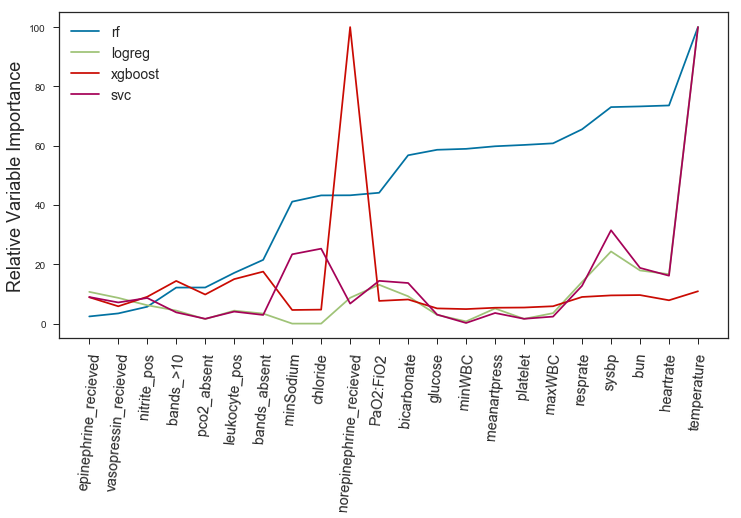

time: 611 ms


In [313]:
x_train= x_train_48
model_dic=models_48_dic

save_boolean=True
folder='48_hr_window'
plot_name='variable_importance_asthetic'


#find set(topN) variables
varimp_names= find_N_varimp_set(x_train, model_dic)

#find rel importance of set(topN) variables for each model
top_set_dic= topN_rel_imp(model_dic, varimp_names)

#plot the variable importance plot
topN_rel_imp_df= plot_topN_rel_imp(top_set_dic, varimp_names, xvar_rotation=85, plot_name=plot_name)

In [269]:
folder

'48_hr_window'

time: 1.97 ms


In [246]:
# def var_imp(model,model_name, timewindow, x_train, n_var=4):
#     model_name=type(model).__name__
#     plot_title= "Top {} {} {} Variable Importance".format(n_var, timewindow,model_name)
#     feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
#     topn=feat_importances.nlargest(n_var).sort_values()
#     return(topn)

def var_imp(model, x_train, n_var=4):
    model_name=type(model).__name__
    #plot_title= "Top {} {} {} Variable Importance".format(n_var, timewindow,model_name)
    feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
    topn=feat_importances.nlargest(n_var).sort_values()
    return(topn)

#log reg important features

def coef_feature_importance(model, x_train):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-10:]#[0]
    pos = np.arange(sorted_idx.shape[0]) + .5

    features,top10 =list(np.array(x_train.columns)[sorted_idx][-10:]), feature_importance[sorted_idx]
    return(features, top10)

time: 13.8 ms


In [247]:
models_dic= models_48_dic
x_train=x_train_48

features_dic={}
top_set_dic={}

n_var=10

for model_name in models_dic.keys():
    model= models_dic[model_name]
    if model_name in ['knn','ensemble']:
        pass
    elif model_name in ['logreg','svc']:
        feature_importance = abs(model.coef_[0])
        sorted_idx = np.argsort(feature_importance)[-n_var:]#[0]
        features =list(np.array(x_train.columns)[sorted_idx][-n_var:])
        features_dic.update( {model_name :features } )
        
    else:
        features=var_imp(model, x_train, n_var=n_var)
        features=list(features.reset_index()['index'])
        features_dic.update( {model_name :features } )

#######
set_features=[]

for features in features_dic.values():
    set_features=set_features+features
set_features=set(set_features)
varimp_names=list(set_features)
#varimp_names

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

time: 61.5 ms


In [45]:
#getting index of the set(top10) variables in x_train
xtrain_column_index_list=[]
for element in varimp_names:
    variable_index=list(x_train).index(element)
    xtrain_column_index_list.append(variable_index)


time: 3.24 ms


In [46]:
top_set_dic={}

#getting index of the set(top10) variables in x_train
xtrain_column_index_list=[]
for element in varimp_names:
    variable_index=list(x_train).index(element)
    xtrain_column_index_list.append(variable_index)


for model_name in models_dic.keys(): ##now that we have set of top N variables for each model. we can make relative importance for all unique variables in the set
    model= models_dic[model_name]
    if model_name in ['knn','ensemble']:
        pass
    elif model_name in ['logreg','svc']:
        imp= abs(model.coef_[0])[xtrain_column_index_list]
        rel_imp=100.0 * (imp / imp.max())
        features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_var:])
        top_set= pd.Series(rel_imp,features).sort_values()
        top_set_dic.update( {model_name :top_set } )
        
    else:
        imp=pd.Series(models_24_dic[model_name].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
        imp=imp.sort_values()
        rel_imp=100.0 * (imp / imp.max())
        features =list(np.array(x_train.columns)[xtrain_column_index_list])
        top_set= rel_imp
        top_set_dic.update( {model_name :top_set } )
    

time: 74.5 ms


In [47]:
top_set_dic

{'logreg': minSodium               0.000000
 platelet                0.182605
 glucose                 0.494123
 minWBC                  1.137038
 maxWBC                  3.234987
 ibands_absent           4.029256
 spo2                    4.676842
 leukocyte_1.0           5.580367
 ibands_>10              5.617337
 nitrite_1.0             7.366538
 bicarbonate             7.725730
 vasopressin_1.0         8.461344
 norepinephrine_1.0      9.314262
 epinephrine_1.0        12.497930
 pao2fio2ratio          17.555093
 resprate               18.752020
 bun                    21.599844
 sysbp                  23.382204
 heartrate              23.587412
 temperature           100.000000
 dtype: float64, 'rf': vasopressin_1.0         2.037494
 epinephrine_1.0         2.451627
 nitrite_1.0             5.272286
 ibands_>10             13.086259
 leukocyte_1.0          18.156388
 ibands_absent          18.687211
 norepinephrine_1.0     45.710715
 minSodium              48.653131
 spo2           

time: 7.25 ms


In [48]:
def roc_name_adjust(varimp_names):
    """
    cleans up the column names for the variable importance plot for publishing
    """
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
            'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
            'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

time: 15.2 ms


In [49]:
def stacked_varimp(top_10_dic,features_dic):
    """
    gets a stacked RELATIVE variable importance plot for all 4 classifiers for a given model dictionary (timewindow)
    """
    set_features=[]
    
    for features in features_dic.values():
        set_features=set_features+features
    set_features=set(set_features)
    varimp_names=list(set_features)
    
    df_base=pd.DataFrame(index=set_features)
    
    for model_name in top_10_dic.keys():
        df_base[model_name]= top_10_dic[model_name]
                
    adjusted_names= roc_name_adjust(varimp_names)
    
    df_base.index=adjusted_names
    df_base.sort_values('xgboost', ascending=False)
    
    plt.style.use('seaborn-ticks')
    plt.rcParams['figure.figsize'] = [7, 7]
    ax = df_base.sort_values('xgboost', ascending=False).plot.barh(stacked=True,
                                                               grid=False,
                                                               color=['r',(0.31,0.50,0.74),(0.35,0.35,0.40),(0.44,0.19,0.63)])#facecolor='w')#rot=0) #(0.96,0.59,0.27)
    ax.set_facecolor('w')
    ax.set_xlabel("Relative Variable Importance")
    return(df_base)

time: 30 ms


In [50]:
# features_dic_24, top_10_dic_24= model_var_imp(models_24_dic, '24_hr_window', x_train_24)
features_dic_24, top_10_dic_24= model_var_imp(top_set_dic, x_train_24)
df_base= stacked_varimp(top_10_dic_24, features_dic_24)

NameError: name 'model_var_imp' is not defined

time: 33.1 ms


Text(0.5, 0, 'Relative Variable Importance')

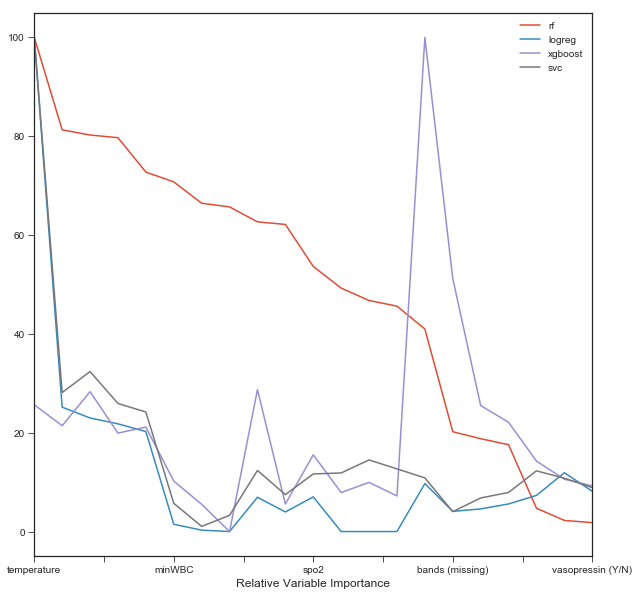

time: 270 ms


In [458]:
#features

df_base=pd.DataFrame(index=features)  

for model_name in top_set_dic.keys():
    df_base[model_name]= top_set_dic[model_name]
    
adjusted_names=roc_name_adjust(features)
df_base.index=adjusted_names
df_base.sort_values('rf', ascending=False)

plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [10,10]#[7, 7]

ax = df_base.sort_values('rf', ascending=False).plot.line(stacked=False,
                                                           grid=False)#,
                                                           #color=['r',(0.31,0.50,0.74),(0.35,0.35,0.40),(0.44,0.19,0.63)])#facecolor='w')#rot=0) #(0.96,0.59,0.27)
ax.set_facecolor('w')
ax.set_xlabel("Relative Variable Importance")

[Text(0, 0, 'temperature'),
 Text(0, 0, 'maxSodium'),
 Text(0, 0, 'bicarbonate'),
 Text(0, 0, 'spo2'),
 Text(0, 0, 'sysbp'),
 Text(0, 0, 'PaO2:FiO2 (475-3000)'),
 Text(0, 0, 'bun'),
 Text(0, 0, 'norepinephrine (Y/N)'),
 Text(0, 0, 'platelet')]

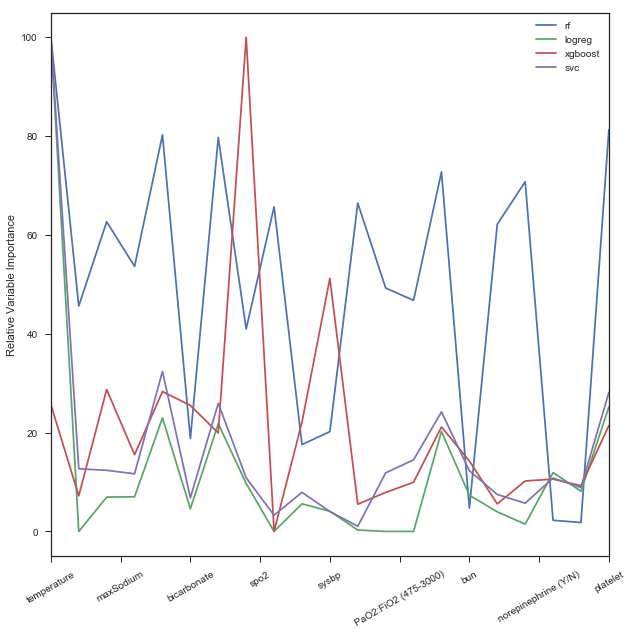

time: 261 ms


In [482]:
#['dummy']=0
#del df_base['dummy']
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [10,10]#[7, 7]
ax = df_base.plot.line()
ax.set_ylabel("Relative Variable Importance")
ax.set_xticklabels(adjusted_names,rotation=30)
#ax.set_xticklabels(adjusted_names)#,rotation=30)

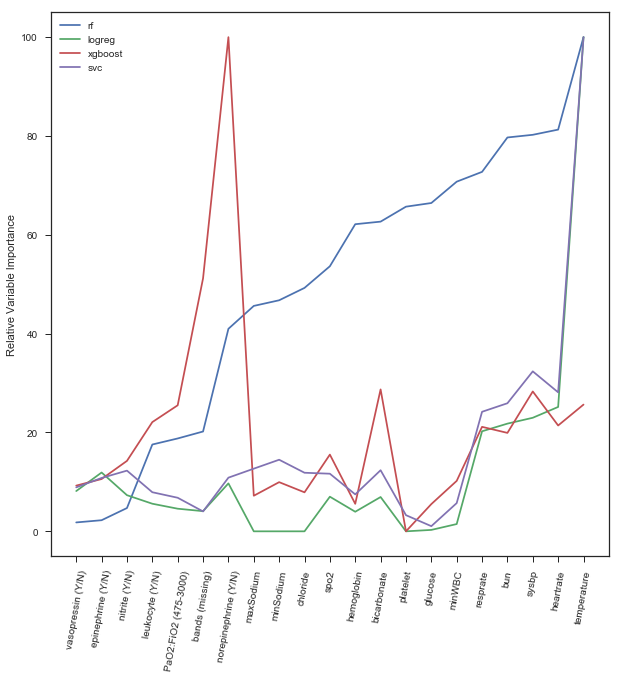

time: 305 ms


In [503]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [10,10]#[7, 7]
plt.plot(df_base.sort_values('rf', ascending=True))
#plt.set_xticklabels(adjusted_names,rotation=30)
plt.xticks(rotation=80)#, ha='right')
plt.ylabel("Relative Variable Importance")
plt.legend(list(df_base))

In [457]:
top_set_dic

{'logreg': maxSodium                      0.000000
 minSodium                      0.000000
 chloride                       0.000000
 platelet                       0.000000
 glucose                        0.285890
 minWBC                         1.472460
 hemoglobin                     3.963781
 ibands_absent                  4.080384
 pao2fio2ratio_(475, 3000]      4.577936
 leukocyte_1.0                  5.585511
 bicarbonate                    6.940209
 spo2                           7.006959
 nitrite_1.0                    7.313703
 vasopressin_1.0                8.150204
 norepinephrine_1.0             9.701868
 epinephrine_1.0               11.900351
 resprate                      20.242377
 bun                           21.793059
 sysbp                         22.979157
 heartrate                     25.169944
 temperature                  100.000000
 dtype: float64, 'rf': vasopressin_1.0                1.800108
 epinephrine_1.0                2.248060
 nitrite_1.0             

time: 4.76 ms


In [445]:
roc_name_adjust(features)

['temperature',
 'maxSodium',
 'bicarbonate',
 'spo2',
 'sysbp',
 'PaO2:FiO2 (475-3000)',
 'bun',
 'norepinephrine (Y/N)',
 'platelet',
 'leukocyte (Y/N)',
 'bands (missing)',
 'glucose',
 'chloride',
 'minSodium',
 'resprate',
 'nitrite (Y/N)',
 'hemoglobin',
 'minWBC',
 'epinephrine (Y/N)',
 'vasopressin (Y/N)',
 'heartrate']

time: 2.19 ms


In [ ]:
# #list of variable importances for svc
# svc_imp= abs(models_24_dic['svc'].coef_[0])[xtrain_column_index_list]
# rel_imp=100.0 * (svc_imp / svc_imp.max())
# features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_var:])

# pd.Series(rel_imp,features).sort_values()

In [431]:
# #list of variable importances for rf
# fi=pd.Series(models_24_dic['rf'].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
# topn=fi.sort_values()
# rel_imp=100.0 * (topn / topn.max())
# #topn=feat_importances.nlargest(n_var).sort_values()

time: 20.6 ms


In [389]:
# models_dic= models_24_dic
# x_train=x_train_24

# features_dic={}
# top_10_dic={}

# n_var=10

# for model_name in models_dic.keys():
#     model= models_dic[model_name]
#     if model_name in ['knn','ensemble']:
#         pass
#     elif model_name in ['logreg','svc']:
#         feature_importance = abs(model.coef_[0])
#         feature_importance = 100.0 * (feature_importance / feature_importance.max())
#         sorted_idx = np.argsort(feature_importance)[-n_var:]#[0]
#         pos = np.arange(sorted_idx.shape[0]) + .5

#         features =list(np.array(x_train.columns)[sorted_idx][-n_var:])
#         features_dic.update( {model_name :features } )
        
#     else:
#         features=var_imp(model, x_train, n_var=n_var)
#         top10=(features/features[-1])*100
#         features=list(features.reset_index()['index'])
#         features_dic.update( {model_name :features } )

# #######
# set_features=[]

# for features in features_dic.values():
#     set_features=set_features+features
# set_features=set(set_features)
# varimp_names=list(set_features)
# varimp_names



['temperature',
 'maxSodium',
 'bicarbonate',
 'spo2',
 'sysbp',
 'pao2fio2ratio_(475, 3000]',
 'bun',
 'norepinephrine_1.0',
 'platelet',
 'leukocyte_1.0',
 'ibands_absent',
 'glucose',
 'chloride',
 'minSodium',
 'resprate',
 'nitrite_1.0',
 'hemoglobin',
 'minWBC',
 'epinephrine_1.0',
 'vasopressin_1.0',
 'heartrate']

time: 135 ms


In [397]:
# xtrain_column_index_list=[]
# for element in varimp_names:
#     variable_index=list(x_train).index(element)
#     xtrain_column_index_list.append(variable_index)

# #models_24_dic['logreg'].coef_[0]

time: 2.68 ms


In [428]:
# #list of variable importances for svc
# svc_imp= abs(models_24_dic['svc'].coef_[0])[xtrain_column_index_list]
# rel_imp=100.0 * (svc_imp / svc_imp.max())
# features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_var:])

# pd.Series(rel_imp,features).sort_values()

glucose                        1.044325
platelet                       3.271289
ibands_absent                  4.027220
minWBC                         5.711475
pao2fio2ratio_(475, 3000]      6.793220
hemoglobin                     7.475689
leukocyte_1.0                  7.910410
vasopressin_1.0                8.898048
epinephrine_1.0               10.798149
norepinephrine_1.0            10.859831
spo2                          11.659259
chloride                      11.853476
nitrite_1.0                   12.280672
bicarbonate                   12.363985
maxSodium                     12.680348
minSodium                     14.488637
resprate                      24.187938
bun                           25.917657
heartrate                     28.126466
sysbp                         32.369085
temperature                  100.000000
dtype: float64

time: 7.61 ms


In [408]:
# fi=pd.Series(models_24_dic['rf'].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
# topn=fi.sort_values()
# rel_imp=100.0 * (topn / topn.max())
# #topn=feat_importances.nlargest(n_var).sort_values()
# 100.0 * (topn / topn.max())

time: 18.8 ms


In [ ]:
models_dic= models_24_dic
x_train=x_train_24

features_dic={}
top_10_dic={}

n_var=10

for model_name in models_dic.keys():
    model= models_dic[model_name]
    if model_name in ['knn','ensemble']:
        pass
    elif model_name in ['logreg','svc']:
        feature_importance = abs(model.coef_[0])
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[-n_var:]#[0]
        pos = np.arange(sorted_idx.shape[0]) + .5

        features =list(np.array(x_train.columns)[sorted_idx][-n_var:])
        features_dic.update( {model_name :features } )
        
    else:
        features=var_imp(model, x_train, n_var=n_var)
        top10=(features/features[-1])*100
        features=list(features.reset_index()['index'])
        features_dic.update( {model_name :features } )

#######
set_features=[]

for features in features_dic.values():
    set_features=set_features+features
set_features=set(set_features)
varimp_names=list(set_features)
varimp_names

varimp_names

In [390]:
len(varimp_names)

21

time: 1.81 ms


In [375]:

def coef_feature_importance(model, x_train, n_var=10):
    model_name=type(model).__name__
    
    if model_name in ['LogisticRegression','SVC']:
        feature_importance = abs(model.coef_[0])
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[-n_var:]#[0]
        pos = np.arange(sorted_idx.shape[0]) + .5

        features =list(np.array(x_train.columns)[sorted_idx][-n_var:])
        top10=feature_importance[sorted_idx]
        
        top10=pd.Series(top10,features) ##new
        
    elif model_name in ['knn','ensemble']:
        pass
    
    else:
        features=var_imp(model, x_train, n_var=n_var)
        top10=(features/features[-1])*100
        features=list(features.reset_index()['index'])

    return(features, top10)

time: 21.7 ms


In [366]:
def model_var_imp(models_dic, x_train):
    """
    makes a dictionary of RELATIVE variable importances for each model in a model dictionary
    """
    features_dic={}
    top_10_dic={}
    
    for model_name in models_dic.keys():
        model= models_dic[model_name]
    
        if model_name in ['knn','ensemble']:
            pass
        else:
            features,top10 =coef_feature_importance(model, x_train)
            features_dic.update( {model_name :features } )
            top_10_dic.update( {model_name :top10 } )
    return(features_dic,top_10_dic)

# def model_var_imp(models_dic, timewindow, x_train):
#     """
#     makes a dictionary of RELATIVE variable importances for each model in a model dictionary
#     """
#     features_dic={}
#     top_10_dic={}
    
#     for model_name in models_dic.keys():
#         model= models_dic[model_name]
    
#         if model_name in ['logreg','svc']:
#             features,top10 =coef_feature_importance(model, x_train)
#             top10=pd.Series(top10,features)

#             features_dic.update( {model_name :features } )
#             top_10_dic.update( {model_name :top10 } )
#         elif model_name in ['knn','ensemble']:
#             pass
#         else:
#             features=var_imp(model,model_name, timewindow, x_train, n_var=10)
#             top10=(features/features[-1])*100
#             features=list(features.reset_index()['index'])
#             features_dic.update( {model_name :features } )
#             top_10_dic.update( {model_name :top10 } )
#     return(features_dic,top_10_dic)

time: 32.7 ms


In [41]:
x_train_24

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,o2_flow,potassium,...,vent_recieved_1.0,vent_recieved_2.0,dobutamine_1.0,dopamine_1.0,epinephrine_1.0,norepinephrine_1.0,phenylephrine_1.0,rrt_1.0,vasopressin_1.0,cancer_elix_1.0
0,0.000000,0.014177,0.004273,0.065760,0.047178,0.072874,0.000000,-0.205869,0.0,0.065443,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.040770,0.037089,-0.300758,-0.053798,0.017360,-0.270369,-0.405820,0.0,-0.033690,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,-0.082229,-0.004314,-0.219047,0.136180,0.092040,-0.132111,-0.077558,0.0,-0.175547,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.000000,0.014177,0.004273,0.065760,-0.021339,0.127153,0.000000,0.072205,0.0,0.065443,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.316061,0.098917,-0.035714,1.934240,-0.029584,0.049416,-0.132111,-0.118605,0.0,-0.103141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.000000,0.268150,0.008507,0.300758,0.098197,0.067173,-0.270369,0.106522,0.0,0.159116,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.305079,-0.167786,-0.008669,-0.069134,0.195552,0.064284,0.000000,0.072205,0.0,-0.103141,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.153014,-0.101564,0.012702,-0.069134,-0.046953,0.017360,0.000000,0.106522,0.0,0.218816,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.617693,-0.030397,-0.021991,-0.142007,0.226936,0.030582,0.000000,0.072205,0.0,-0.290285,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.845777,0.109375,0.025059,0.000000,0.101904,0.030582,0.364376,0.072205,0.0,-0.068061,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 76.3 ms


In [359]:
def roc_name_adjust(varimp_names):
    """
    cleans up the column names for the variable importance plot for publishing
    """
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
            'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
            'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

time: 13.1 ms


In [341]:
def stacked_varimp(top_10_dic,features_dic):
    """
    gets a stacked RELATIVE variable importance plot for all 4 classifiers for a given model dictionary (timewindow)
    """
    set_features=[]
    
    for features in features_dic.values():
        set_features=set_features+features
    set_features=set(set_features)
    varimp_names=list(set_features)
    
    df_base=pd.DataFrame(index=set_features)
    
    for model_name in top_10_dic.keys():
        df_base[model_name]= top_10_dic[model_name]
                
    adjusted_names= roc_name_adjust(varimp_names)
    
    df_base.index=adjusted_names
    df_base.sort_values('xgboost', ascending=False)
    
    plt.style.use('seaborn-ticks')
    plt.rcParams['figure.figsize'] = [7, 7]
    ax = df_base.sort_values('xgboost', ascending=False).plot.barh(stacked=True,
                                                               grid=False,
                                                               color=['r',(0.31,0.50,0.74),(0.35,0.35,0.40),(0.44,0.19,0.63)])#facecolor='w')#rot=0) #(0.96,0.59,0.27)
    ax.set_facecolor('w')
    ax.set_xlabel("Relative Variable Importance")
    return(df_base)

time: 25.8 ms


In [356]:
models_24_dic['ensemble'].

KeyError: 'ensemble'

time: 11.7 ms


In [350]:
models_24_dic_ne= models_24_dic
del models_24_dic_ne['ensemble']

time: 874 µs


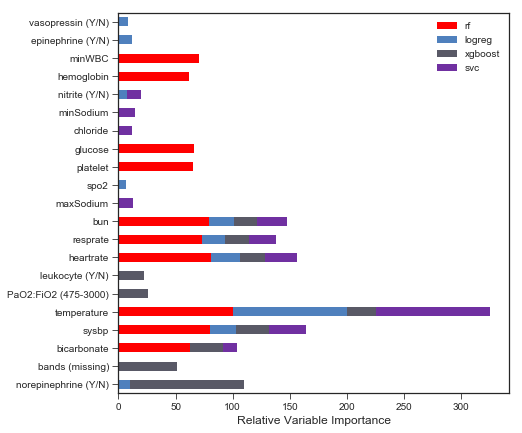

time: 479 ms


In [376]:
# features_dic_24, top_10_dic_24= model_var_imp(models_24_dic, '24_hr_window', x_train_24)
features_dic_24, top_10_dic_24= model_var_imp(models_24_dic, x_train_24)
df_base= stacked_varimp(top_10_dic_24, features_dic_24)

In [353]:
top_10_dic_24

{'logreg': spo2                    7.006959
 nitrite_1.0             7.313703
 vasopressin_1.0         8.150204
 norepinephrine_1.0      9.701868
 epinephrine_1.0        11.900351
 resprate               20.242377
 bun                    21.793059
 sysbp                  22.979157
 heartrate              25.169944
 temperature           100.000000
 dtype: float64, 'rf': hemoglobin      62.146402
 bicarbonate     62.667565
 platelet        65.695352
 glucose         66.435455
 minWBC          70.753528
 resprate        72.738136
 bun             79.697609
 sysbp           80.238640
 heartrate       81.288113
 temperature    100.000000
 dtype: float64, 'svc': chloride        11.853476
 nitrite_1.0     12.280672
 bicarbonate     12.363985
 maxSodium       12.680348
 minSodium       14.488637
 resprate        24.187938
 bun             25.917657
 heartrate       28.126466
 sysbp           32.369085
 temperature    100.000000
 dtype: float64, 'xgboost': bun                           19.9175

time: 4.71 ms


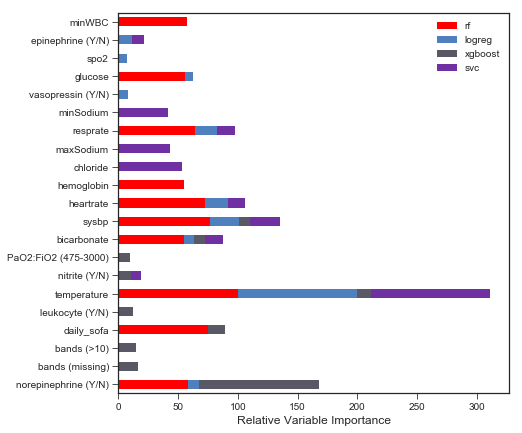

time: 605 ms


In [147]:
features_dic_48, top_10_dic_48= model_var_imp(models_48_dic, '48_hr_window', x_train_48)
df_base= stacked_varimp(top_10_dic_48, features_dic_48)

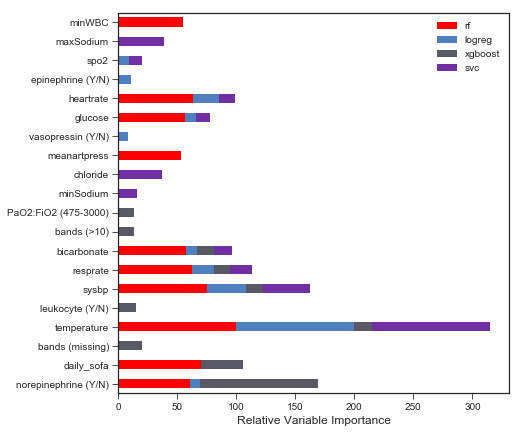

time: 481 ms


In [148]:
features_dic_72, top_10_dic_72= model_var_imp(models_72_dic, '72_hr_window', x_train_72)
df_base= stacked_varimp(top_10_dic_72, features_dic_72)

In [ ]:
#tomorrow remember to test removing SOFA score